# Milestone 3 - the daTaBABES

This notebook contains our analysis of the data contained in the beer datasets from two websites BeerAdvocate (BA) and RateBeer (RB). The goal of this analysis is to answer the following question:  
**What would be the ideal beer for the US consumer depending on the month?**


In [1]:
# imports

import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

import re
import spacy
from collections import Counter

import json

from scipy.stats import f_oneway
from sklearn import linear_model
import statsmodels.api as sm
import scipy.stats as st
import math

In [2]:
# Turn off warnings
import warnings

warnings.filterwarnings('ignore')

Users have rated the beers from two websites, RateBeer and BeerAdvocate, thus we get reviews of users from two distinct datasets. The reviews are in txt files, thus we convert the txt files into csv so that we can manipulate the data more easily. By doing this, we get as much as data as we can.

The conversion of the txt files into csv files is done in the notebook 'preprocessing_txt.ipynb'.

# Preprocessing

## Step 0: Loading the datasets

In [3]:
# Loading the ratings datasets 
ratings_ba_df = pd.read_csv('data/BeerAdvocate/ratings_BA.csv')
ratings_rb_df = pd.read_csv('data/RateBeer/ratings_RB.csv')
ratings_matched_df = pd.read_csv('data/matched_beer_data/ratings.csv')

# Loading the users dataset 
users_ba_df = pd.read_csv('data/BeerAdvocate/users.csv')
users_rb_df = pd.read_csv('data/RateBeer/users.csv')
users_matched_df = pd.read_csv('data/matched_beer_data/users.csv')

# Loading the beers dataset
beers_ba_df = pd.read_csv('data/BeerAdvocate/beers.csv')
beers_rb_df = pd.read_csv('data/RateBeer/beers.csv')
beers_matched_df = pd.read_csv('data/matched_beer_data/beers.csv')

In [4]:
# Convert the date column to datetime format for BeerAdvocate
ratings_ba_df['date'] = pd.to_datetime(ratings_ba_df['date'], unit='s')
ratings_ba_df['year'] = ratings_ba_df['date'].dt.year
ratings_ba_df['month'] = ratings_ba_df['date'].dt.month

# Convert the date column to datetime format for RateBeer
ratings_rb_df['date'] = pd.to_datetime(ratings_rb_df['date'], unit='s')
ratings_rb_df['year'] = ratings_rb_df['date'].dt.year
ratings_rb_df['month'] = ratings_rb_df['date'].dt.month

In [5]:
# Create a year_month column
ratings_ba_df['year_month'] = ratings_ba_df['year'].astype(str) + '-' + ratings_ba_df['month'].astype(str)
ratings_rb_df['year_month'] = ratings_rb_df['year'].astype(str) + '-' + ratings_rb_df['month'].astype(str)

# Convert the year_month column to datetime format
ratings_ba_df['year_month'] = pd.to_datetime(ratings_ba_df['year_month'])
ratings_rb_df['year_month'] = pd.to_datetime(ratings_rb_df['year_month'])


In [6]:
# Create copy of original datasets
ratings_ba_df_untouched = ratings_ba_df.copy()
ratings_rb_df_untouched = ratings_rb_df.copy()
beers_ba_df_untouched = beers_ba_df.copy()
beers_rb_df_untouched = beers_rb_df.copy()

In [7]:
# Print the number of ratings in each dataset
nbr_ratings_ba = ratings_ba_df.shape[0]
nbr_ratings_rb = ratings_rb_df.shape[0]

print('Number of ratings in BeerAdvocate: {}'.format(nbr_ratings_ba))
print('Number of ratings in RateBeer: {}'.format(nbr_ratings_rb))

Number of ratings in BeerAdvocate: 2715712
Number of ratings in RateBeer: 7122074


Names of brewery id don't match for both datasets:

In [8]:
beers_matched_df.head(2)

,ba,ba.1,ba.2,ba.3,ba.4,ba.5,ba.6,ba.7,ba.8,ba.9,...,rb.7,rb.8,rb.9,rb.10,rb.11,rb.12,rb.13,rb.14,scores,scores.1
0,abv,avg,avg_computed,avg_matched_valid_ratings,ba_score,beer_id,beer_name,beer_wout_brewery_name,brewery_id,brewery_name,...,brewery_id,brewery_name,nbr_matched_valid_ratings,nbr_ratings,overall_score,style,style_score,zscore,diff,sim
1,4.8,3.45,3.439866666666666,3.504067796610169,80.0,19827,Legbiter,Legbiter,10093,Strangford Lough Brewing Company Ltd,...,4959,Strangford Lough,89,89,23.0,Golden Ale/Blond Ale,27.0,-0.69830388113311,1.0,1.0


Names of beer styles don't match for both datasets:

In [9]:
ratings_matched_df.head(2)

,ba,ba.1,ba.2,ba.3,ba.4,ba.5,ba.6,ba.7,ba.8,ba.9,...,rb.6,rb.7,rb.8,rb.9,rb.10,rb.11,rb.12,rb.13,rb.14,rb.15
0,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,brewery_name,date,overall,palate,rating,style,taste,text,user_id,user_name
1,11.3,4.5,4.5,645,Trappistes Rochefort 10,207,Brasserie de Rochefort,1324810800,5.0,4.5,...,Brasserie Rochefort,1387710000,19.0,4.0,4.6,Abt/Quadrupel,9.0,a) Geruch malzig-schwer-sÃ¼Ã. Riecht schon ...,83106,Erzengel


In [10]:
# print column name and first row to get the real column name
for col in beers_matched_df.columns:
    print(beers_matched_df[col].head(1))
    print('-----------------------')

0    abv
Name: ba, dtype: object
-----------------------
0    avg
Name: ba.1, dtype: object
-----------------------
0    avg_computed
Name: ba.2, dtype: object
-----------------------
0    avg_matched_valid_ratings
Name: ba.3, dtype: object
-----------------------
0    ba_score
Name: ba.4, dtype: object
-----------------------
0    beer_id
Name: ba.5, dtype: object
-----------------------
0    beer_name
Name: ba.6, dtype: object
-----------------------
0    beer_wout_brewery_name
Name: ba.7, dtype: object
-----------------------
0    brewery_id
Name: ba.8, dtype: object
-----------------------
0    brewery_name
Name: ba.9, dtype: object
-----------------------
0    bros_score
Name: ba.10, dtype: object
-----------------------
0    nbr_matched_valid_ratings
Name: ba.11, dtype: object
-----------------------
0    nbr_ratings
Name: ba.12, dtype: object
-----------------------
0    nbr_reviews
Name: ba.13, dtype: object
-----------------------
0    style
Name: ba.14, dtype: object
--------

## Step 1: Only keep ratings from US users

To start our analysis, we look at the distribution of unique users across different countries. We would like to focus on a single country for our analysis as ratings from users from different regions can introduce mixed results that represents no country in reality. For example a certain type of beer can be appreciated in summer and not in winter. But depending on the region of the worls, summer and winter are in different time of the year. So looking at the rating of that beer for each month for each users will not showcase this particularity. By narrowing down to one country, we get a clearer picture of what people in that specific place like. This helps us avoid getting mixed results that might be affected by different tastes and seasons in different parts of the world.

In [11]:
# Extract the country from the location
users_rb_df['location'] = users_rb_df['location'].str.split(',').str[0]
users_ba_df['location'] = users_ba_df['location'].str.split(',').str[0]

In [12]:
# Number of users per country, in RateBeer
rb_user_count_country = users_rb_df.groupby('location')['location'].count().sort_values(ascending=False).reset_index(name='nb users in RateBeer')

# Number of users per country, in BeerAdvocate
ba_user_count_country = users_ba_df.groupby('location')['location'].count().sort_values(ascending=False).reset_index(name='nb users in BeerAdvocate')

In [13]:
# Merge the two above data frames to count the total number of users per country
users_country = rb_user_count_country.merge(ba_user_count_country, on='location')
users_country['total nb of users'] = users_country['nb users in RateBeer'] + users_country['nb users in BeerAdvocate']
users_country = users_country.sort_values('total nb of users', ascending=False)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'United States'),
  Text(1, 0, 'Canada'),
  Text(2, 0, 'England'),
  Text(3, 0, 'Australia'),
  Text(4, 0, 'Poland'),
  Text(5, 0, 'Netherlands'),
  Text(6, 0, 'Sweden'),
  Text(7, 0, 'Germany'),
  Text(8, 0, 'Belgium'),
  Text(9, 0, 'Denmark')])

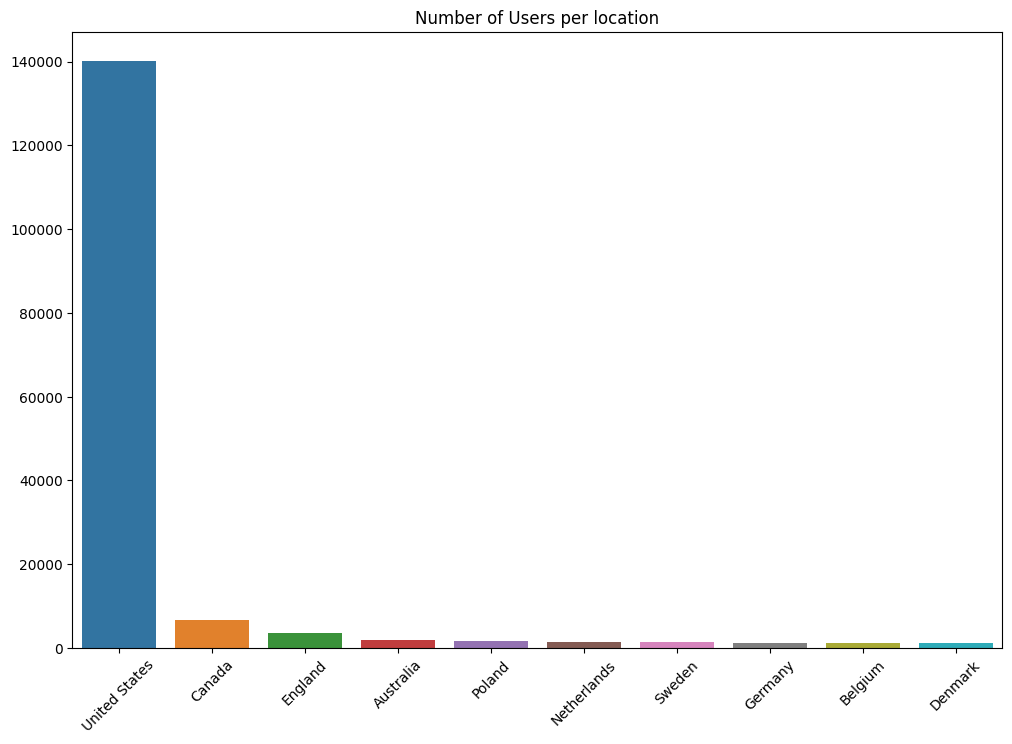

In [14]:
# Plot the distribution of the number of users per country
plt.figure(figsize=(12,8))
sns.barplot(x=users_country['location'].values[:10], y=users_country['total nb of users'].values[:10])
plt.title('Number of Users per location')
plt.xticks(rotation=45)

As we see, the US has much more users than the other countries. This leads us to think that by focusing on this country, we will get the most diverse reviews as they come from many different users. If we would consider Canada for example, we could have bias results as there are not so many users and the reviews come from a small set of people, leading us to provide a perfect beer for very few people. For this reason, our analysis will be focused on the US only.

In [15]:
US_country = 'United States'

# Keep only the rows where the user country is United States
users_ba_df_us = users_ba_df[users_ba_df.location == US_country]
users_rb_df_us = users_rb_df[users_rb_df.location == US_country]

# Keep only the rows where the user country is not from United States
users_ba_df_ca = users_ba_df[users_ba_df.location != US_country]
users_rb_df_ca = users_rb_df[users_rb_df.location != US_country]

In [16]:
# Merge the ratings and users data frames to get the location of the user for each rating
ratings_users_ba_df_us = pd.merge(ratings_ba_df, users_ba_df_us[['user_id', 'location']], on='user_id', how='inner')
ratings_users_rb_df_us = pd.merge(ratings_rb_df, users_rb_df_us[['user_id', 'location']], on='user_id', how='inner')

ratings_users_ba_df_ca = pd.merge(ratings_ba_df, users_ba_df_ca[['user_id', 'location']], on='user_id', how='inner')
ratings_users_rb_df_ca = pd.merge(ratings_rb_df, users_rb_df_ca[['user_id', 'location']], on='user_id', how='inner')

Filtered dataframe to separate ratings from US users from the rest

In [17]:
# filter the ratings dataframes to only keep ratings of the users from the US
ratings_ba_df_us = ratings_users_ba_df_us[ratings_users_ba_df_us.location == US_country]
ratings_ba_df_us.drop('location', axis=1, inplace=True)
ratings_rb_df_us = ratings_users_rb_df_us[ratings_users_rb_df_us.location == US_country]
ratings_rb_df_us.drop('location', axis=1, inplace=True)

# filter the ratings dataframes to only keep ratings of the users not from US
ratings_ba_df_ca = ratings_users_ba_df_ca[ratings_users_ba_df_ca.location != US_country]
ratings_ba_df_ca.drop('location', axis=1, inplace=True)
ratings_rb_df_ca = ratings_users_rb_df_ca[ratings_users_rb_df_ca.location != US_country]
ratings_rb_df_ca.drop('location', axis=1, inplace=True)


Number of ratings from the US in BeerAdvocate: 2346494
Number of ratings from the US in Ratebeer: 3108958
Number of ratings not from US in BeerAdvocate: 369218
Number of ratings not from US in Ratebeer: 4014825


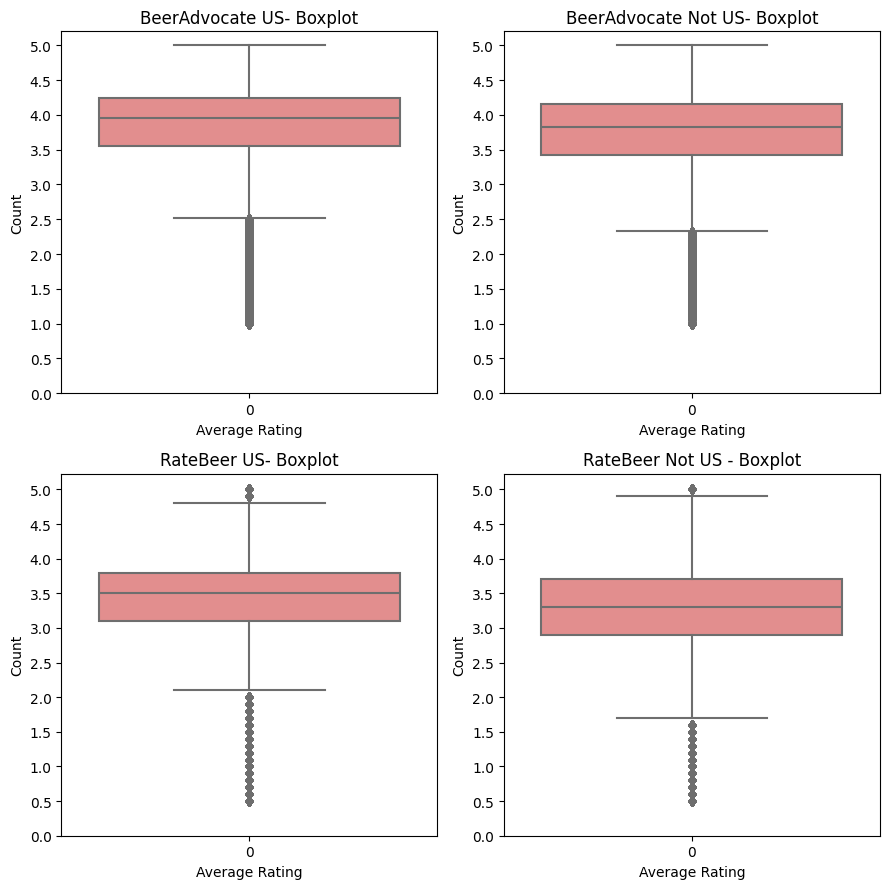

In [18]:
# Plot the distribution of the number of ratings per user
fig, axes = plt.subplots(2, 2, figsize=(9, 9))

# Number of beers in BeerAdvocate and RateBeer
print("Number of ratings from the US in BeerAdvocate:", len(ratings_ba_df_us))
print("Number of ratings from the US in Ratebeer:", len(ratings_rb_df_us))
print("Number of ratings not from US in BeerAdvocate:", len(ratings_ba_df_ca))
print("Number of ratings not from US in Ratebeer:", len(ratings_rb_df_ca))

# BeerAdvocate US- Boxplot
sns.boxplot(ratings_ba_df_us['rating'], ax=axes[0, 0], color='lightcoral')
axes[0, 0].set_xlabel('Average Rating')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('BeerAdvocate US- Boxplot')
axes[0, 0].set_yticks(np.arange(0, 5.5, 0.5))

# BeerAdvocate Not US- Boxplot
sns.boxplot(ratings_ba_df_ca['rating'], ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_xlabel('Average Rating')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('BeerAdvocate Not US- Boxplot')
axes[0, 1].set_yticks(np.arange(0, 5.5, 0.5))

# RateBeer US- Boxplot
sns.boxplot(ratings_rb_df_us['rating'], ax=axes[1, 0], color='lightcoral')
axes[1, 0].set_xlabel('Average Rating')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('RateBeer US- Boxplot')
axes[1, 0].set_yticks(np.arange(0, 5.5, 0.5))

# RateBeer Not US - Boxplot
sns.boxplot(ratings_rb_df_ca['rating'], ax=axes[1, 1], color='lightcoral')
axes[1, 1].set_xlabel('Average Rating')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('RateBeer Not US - Boxplot')
axes[1, 1].set_yticks(np.arange(0, 5.5, 0.5))

plt.tight_layout()
plt.show()

As we can see from the boxplots above, the distribution of the ratings from the users from the US and the others are close for both datasets, but with the average rating being slightly higher when ratings come from US users.  
This means that removing users not from the US won't change the general ratings distribution much and that filtering on good ratings before or after filtering on the users location does not have a big impact on the overall rating distribution. 

Filter the datasets to only keep users from the US:

In [19]:
ratings_ba_df = ratings_ba_df_us
ratings_rb_df = ratings_rb_df_us

In [20]:
nbr_ratings_ba = ratings_ba_df.shape[0]
nbr_ratings_rb = ratings_rb_df.shape[0]

print('Number of ratings in BeerAdvocate: {}'.format(nbr_ratings_ba))
print('Number of ratings in RateBeer: {}'.format(nbr_ratings_rb))

Number of ratings in BeerAdvocate: 2346494
Number of ratings in RateBeer: 3108958


### Are there users who excessively rate a beer in a short time period ?

Motivation: we want to handle the cases where we could have many ratings from a specific user for the same beer as it could be a user that is trying to bias the rating of a particular beer

In [21]:
# Assuming ratings_combined_df is your DataFrame
threshold = 3  # Adjust this threshold based on your criteria

# Group by user_id, beer_id, and year_month, and count the number of ratings
user_beer_counts_ba = ratings_ba_df.groupby(['user_id', 'beer_id', 'year_month']).size().reset_index(name='rating_count')
user_beer_counts_rb = ratings_rb_df.groupby(['user_id', 'beer_id', 'year_month']).size().reset_index(name='rating_count')

# Filter for instances where the rating count exceeds the threshold
excessive_ratings_ba = user_beer_counts_ba[user_beer_counts_ba['rating_count'] > threshold]
excessive_ratings_rb = user_beer_counts_rb[user_beer_counts_rb['rating_count'] > threshold]

print("Excessive ratings for BeerAdvocate:")
print(excessive_ratings_ba)
print("Excessive ratings for RateBeer:")
print(excessive_ratings_rb)

Excessive ratings for BeerAdvocate:
Empty DataFrame
Columns: [user_id, beer_id, year_month, rating_count]
Index: []
Excessive ratings for RateBeer:
         user_id  beer_id year_month  rating_count
184060      3070      252 2002-11-01             5
184061      3070      403 2002-01-01             5
184062      3070      411 2002-01-01             5
184063      3070      474 2002-01-01             5
184064      3070      707 2002-01-01             5
1474422    46797       46 2007-01-01            41
1474423    46797       86 2007-03-01            41
1474424    46797       87 2007-01-01            41
1474425    46797      145 2007-01-01            41
1474426    46797      589 2007-02-01            41
1474427    46797      594 2007-02-01            41
1474428    46797      662 2007-03-01            41
1474429    46797      663 2007-03-01            41
1474430    46797      690 2007-01-01            41
1474431    46797      714 2007-01-01            41
1474432    46797      745 2007-02-01

We decided to set the threshold to 3 as rating a same beer more than 3 times per month can seem suspicious. We have identified two users in RateBeer who rated the same beer excessively within a specific month. For example, user 46797 has rated 41 times many beers each month from december 2006 to march 2007.  
Such behavior is suspicious, and as a precautionary measure, we've decided to remove these users from the dataset to keep the reliability of the ratings.

In [22]:
# Remove the suspicious users
users_to_remove = [46797, 3070]
ratings_combined_df = ratings_ba_df[~ratings_ba_df['user_id'].isin(users_to_remove)]


## Step 2: What is a popular beer ?

**Popularity definition:** By popular we mean with respect to the number of **good** reviews


#### Distribution of the average rating in BeerAdvocate

In [23]:
ratings_ba_df[['appearance', 'aroma', 'palate', 'style', 'taste', 'overall', 'rating']].describe()

,appearance,aroma,palate,taste,overall,rating
count,2.310684e+06,2.310684e+06,2.310684e+06,2.310684e+06,2.310684e+06,2.346494e+06
mean,3.900441e+00,3.811440e+00,3.817201e+00,3.854748e+00,3.862540e+00,3.846907e+00
std,5.870042e-01,6.626348e-01,6.496978e-01,6.964354e-01,6.714755e-01,6.044712e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.550000e+00
50%,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,3.950000e+00
75%,4.250000e+00,4.250000e+00,4.250000e+00,4.500000e+00,4.250000e+00,4.240000e+00
max,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00


#### Distribution of the average rating in RateBeer

In [24]:
ratings_rb_df[['appearance', 'aroma', 'palate', 'style', 'taste', 'overall', 'rating']].describe()

,appearance,aroma,palate,taste,overall,rating
count,3.108958e+06,3.108958e+06,3.108958e+06,3.108958e+06,3.108958e+06,3.108958e+06
mean,3.536766e+00,6.581593e+00,3.381866e+00,6.651427e+00,1.364188e+01,3.379354e+00
std,7.864937e-01,1.540261e+00,8.069702e-01,1.529019e+00,3.127803e+00,6.799184e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e-01
25%,3.000000e+00,6.000000e+00,3.000000e+00,6.000000e+00,1.200000e+01,3.100000e+00
50%,4.000000e+00,7.000000e+00,3.000000e+00,7.000000e+00,1.400000e+01,3.500000e+00
75%,4.000000e+00,8.000000e+00,4.000000e+00,8.000000e+00,1.600000e+01,3.800000e+00
max,5.000000e+00,1.000000e+01,5.000000e+00,1.000000e+01,2.000000e+01,5.000000e+00


Number of beers in BeerAdvocate: 2346494
Number of beers in RateBeer: 3108958


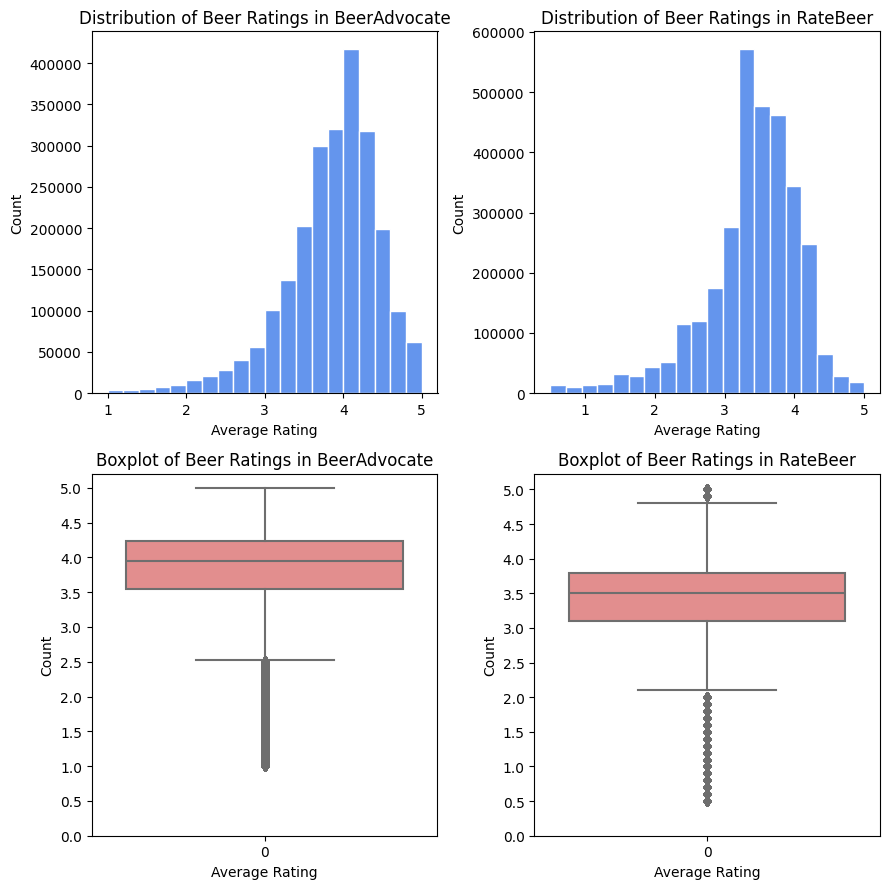

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(9, 9))

# Number of beers in BeerAdvocate and RateBeer
print("Number of beers in BeerAdvocate:", len(ratings_ba_df))
print("Number of beers in RateBeer:", len(ratings_rb_df))

# BeerAdvocate - Histogram
axes[0, 0].hist(ratings_ba_df['rating'], bins=20, color='cornflowerblue', edgecolor='white')
axes[0, 0].set_xlabel('Average Rating')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Distribution of Beer Ratings in BeerAdvocate')

# RateBeer - Histogram
axes[0, 1].hist(ratings_rb_df['rating'], bins=20, color='cornflowerblue', edgecolor='white')
axes[0, 1].set_xlabel('Average Rating')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Distribution of Beer Ratings in RateBeer')
axes[0, 1].ticklabel_format(style="plain", axis="y")

# BeerAdvocate - Boxplot
sns.boxplot(ratings_ba_df['rating'], ax=axes[1, 0], color='lightcoral')
axes[1, 0].set_xlabel('Average Rating')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Boxplot of Beer Ratings in BeerAdvocate')
axes[1, 0].set_yticks(np.arange(0, 5.5, 0.5))

# RateBeer - Boxplot
sns.boxplot(ratings_rb_df['rating'], ax=axes[1, 1], color='lightcoral')
axes[1, 1].set_xlabel('Average Rating')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Boxplot of Beer Ratings in RateBeer')
axes[1, 1].set_yticks(np.arange(0, 5.5, 0.5))

plt.tight_layout()
plt.show()

In [26]:
mean_ba = ratings_ba_df.rating.mean()
mean_rb = ratings_rb_df.rating.mean()

print("Mean rating in BeerAdvocate:", mean_ba)
print("Mean rating in RateBeer:", mean_rb)

Mean rating in BeerAdvocate: 3.846906563579535
Mean rating in RateBeer: 3.3793541115704993


### T-test on the ratings of the two datasets

Let's quantify the observed results with a t-test. 

In [27]:
t_statistic, p_value = st.ttest_ind(ratings_ba_df['rating'], ratings_rb_df['rating'])

# Output the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

if p_value < 0.05:
    print("The ratings in the two datasets are statistically different.")
else:
    print("There is no significant difference in the ratings between the two datasets.")


T-Statistic: 833.6675344272143
P-Value: 0.0
The ratings in the two datasets are statistically different.


As observed from the tables and the plot above, even though the distributions have a similar shape, i.e. normal distribution, they have a different average mean ratings. Indeed, users from the RateBeer dataset seem to be harsher in their ratings.

Now, as defined above, our popularity definition concerns the number of good ratings. A question that arises is: what can be considered as a good rating?

The ratings are continuous numbers between 0 to 5. One idea is to keep the ratings above the average mean of the two datasets and consider them as good rating. With this, we take in account the different distribution of the ratings into the two datasets and find a relatively good threshold.

Let's see what are the 10 most rated beer styles in each dataset:

Number of Beer Styles in AdvocateBeer: 104
Number of Beer Styles in RateBeer: 90


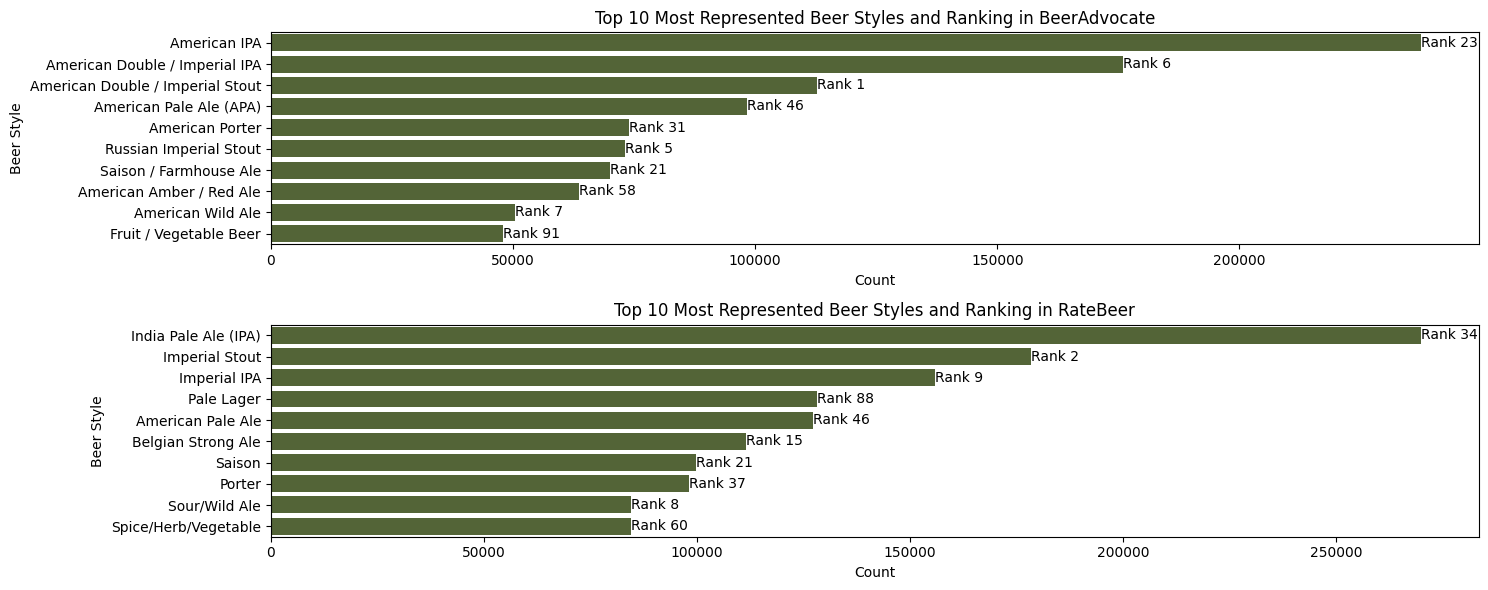

In [28]:
top_ratings_by_style_ba = ratings_ba_df.groupby('style')['rating'].mean().sort_values(ascending=False)
top_ratings_by_style_rb = ratings_rb_df.groupby('style')['rating'].mean().sort_values(ascending=False)

print(f"Number of Beer Styles in AdvocateBeer: {len(top_ratings_by_style_ba)}")
print(f"Number of Beer Styles in RateBeer: {len(top_ratings_by_style_rb)}")

# Number of top beer styles to plot
x = 10

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 6))

# BeerAdvocate
plot1 = sns.countplot(y='style', data=ratings_ba_df, order=ratings_ba_df['style'].value_counts().index[:x], color='darkolivegreen', ax=axes[0])
for i, style in enumerate(ratings_ba_df['style'].value_counts().index[:x]):
    ranking = top_ratings_by_style_ba.index.get_loc(style) + 1  
    plot1.text(ratings_ba_df['style'].value_counts()[i], i, f'Rank {ranking}', va='center')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Beer Style')
axes[0].set_title(f'Top {x} Most Represented Beer Styles and Ranking in BeerAdvocate')

# RateBeer
plot2 = sns.countplot(y='style', data=ratings_rb_df, order=ratings_rb_df['style'].value_counts().index[:x], color='darkolivegreen', ax=axes[1])
for i, style in enumerate(ratings_rb_df['style'].value_counts().index[:x]):
    ranking = top_ratings_by_style_rb.index.get_loc(style) + 1  
    plot2.text(ratings_rb_df['style'].value_counts()[i], i, f'Rank {ranking}', va='center')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Beer Style')
axes[1].set_title(f'Top {x} Most Represented Beer Styles and Ranking in RateBeer')

plt.tight_layout()
plt.show()

From the two plots above we can observe that a beer style can be popular but not have the best rating. For example in the plot of the RateBeer dataset, we see that the 3rd most popular beer style with respect to “count” is the 91th most popular beer style (over 93) when it comes to mean average rating.

So how to rank beers by taking in account their average rating as well as the number of good ratings they received? 

We will use the Lower Bound of Wilson: it presents the "usefulness" value of a product to the user with a 95% confidence interval. In our case, we talk about "popularity" instead of "usefulness". 

In our context, we consider the number of positive ratings as the number of good ratings (ratings over the average rating), and we consider as negative ratings the number of bad ratings (ratings under the average rating). 

As seen previously, the average rating on the datasets is different. Thus, we will first count the number of positive and negative ratings separately, and after this combine everything. 

In [29]:
def wilson_lower_bound(pos, neg, confidence=0.95):
    """
    Wilson Lower Bound score confidence metric.
    Parameters
    ----------
    pos: int
        Number of positive ratings
    neg: int
        Number of negative ratings
    confidence: float
        Confidence level.
    Returns
    -------
    Wilson score: float
        Wilson score lower bound.
    """
    n = pos + neg
    if n == 0:
        return 0
    z = st.norm.ppf(1 - (1 - confidence) / 2)
    phat = 1.0 * pos / n
    return (phat + z * z / (2 * n) - z * math.sqrt((phat * (1 - phat) + z * z / (4 * n)) / n)) / (1 + z * z / n)

In [30]:
# for RateBeer dataset 

average_rating = ratings_rb_df.rating.mean()

beer_rating_rb_df = ratings_rb_df.copy()

beer_rating_rb_df['above_average'] = beer_rating_rb_df['rating'] > average_rating
beer_rating_rb_df['below_average'] = beer_rating_rb_df['rating'] <= average_rating

# group by beer_id and compute the average rating and the number of ratings for each beer
beer_rating_rb_df = beer_rating_rb_df.groupby('beer_id').agg({'rating': ['mean', 'count'], 'above_average': 'sum', 'below_average': 'sum'})
beer_rating_rb_df.rename(columns={'rating': 'average_rating', 'beer_id': 'count'}, inplace=True)
beer_rating_rb_df.reset_index(inplace=True)

# for BeerAdvocate dataset

average_rating = ratings_ba_df.rating.mean()

beer_rating_ba_df = ratings_ba_df.copy()

beer_rating_ba_df['above_average'] = beer_rating_ba_df['rating'] > average_rating
beer_rating_ba_df['below_average'] = beer_rating_ba_df['rating'] <= average_rating

# group by beer_id and compute the average rating and the number of ratings for each beer
beer_rating_ba_df = beer_rating_ba_df.groupby('beer_id').agg({'rating': ['mean', 'count'], 'above_average': 'sum', 'below_average': 'sum'})
beer_rating_ba_df.rename(columns={'rating': 'average_rating', 'beer_id': 'count'}, inplace=True)
beer_rating_ba_df.reset_index(inplace=True)

In [31]:
beer_rating_ba_df.columns = ['beer_id', 'average_rating', 'number_of_ratings', "above_average", "below_average"]
beer_rating_rb_df.columns = ['beer_id', 'average_rating', 'number_of_ratings', "above_average", "below_average"]

In [32]:
# concatenate the two dataframes
beer_rating_df = pd.concat([beer_rating_ba_df, beer_rating_rb_df], ignore_index=True)

# group by beer_id and compute the average rating and the number of ratings for each beer
beer_rating_df = beer_rating_df.groupby('beer_id').agg({'average_rating': 'mean', 'number_of_ratings': 'sum', 'above_average': 'sum', 'below_average': 'sum'})
beer_rating_df.reset_index(inplace=True)

In [33]:
# compute the lower bound of the average rating for each beer
beer_rating_df['lower_bound'] = beer_rating_df.apply(lambda row: wilson_lower_bound(row['above_average'], row['below_average']), axis=1)

# sort the dataframe by the lower bound of the average rating
beer_rating_df.sort_values(by='lower_bound', ascending=False, inplace=True)

beer_rating_df.head(10)

,beer_id,average_rating,number_of_ratings,above_average,below_average,lower_bound
95845,113283,4.348602,187,187,0,0.979871
101955,122097,4.221429,252,251,1,0.977868
4627,4934,4.465517,1653,1627,26,0.977053
101100,120812,4.061967,305,303,2,0.976410
13091,14232,4.321238,1874,1842,32,0.975994
50580,58057,4.444444,225,224,1,0.975259
45917,52649,4.163827,669,660,9,0.974632
74811,86237,4.685437,664,655,9,0.974442
126286,159307,4.237956,274,272,2,0.973781
19626,21690,4.121717,934,919,15,0.973672


In [34]:
# print average count of ratings for each beer
print("Average count of ratings for each beer:", beer_rating_df['number_of_ratings'].mean())

Average count of ratings for each beer: 17.760425042891697


In [35]:
# sort beers by their count of ratings and then by average rating
beer_rating_df.sort_values(by=['number_of_ratings', 'average_rating'], ascending=False, inplace=True)

# print the top 10 beers with the highest count of ratings
beer_rating_df.head(10)

,beer_id,average_rating,number_of_ratings,above_average,below_average,lower_bound
665,680,4.132918,5497,4943,554,0.890979
1048,1093,3.729693,4551,3502,1049,0.757041
402,412,2.724744,4168,3221,947,0.759824
1049,1094,3.856808,3854,2866,988,0.729620
2001,2093,3.873843,3727,3250,477,0.860905
10843,11757,4.470854,3711,3514,197,0.939228
7461,7971,4.598017,3662,3549,113,0.963031
15650,17112,3.763677,3477,3240,237,0.922975
99,104,3.618084,3376,1894,1482,0.544219
1827,1904,3.751282,3287,2753,534,0.824539


**Conlusion**: 
* On the first table, we observe the beers sorted by their lower bound of Wilson. The first beer got a number of 187 reviews, which is higher than the average number of reviews. And it got no reviews below. 
* On the second table, we observe the beers sorted first by their number of reviews and then by their average rating. If we observe the second beer, 1/3 of the ratings are below of the average rating. Eventhough the number of reviews is high, there are a lot of bad reviews, meaning that the beer is not really that appreciated.

## Step 3: Names have to match between the two datasets

Motivation: We noticed that beer styles names vary across the two datasets and we want them to match to be able to process the data correctly.

In the matched beer dataset, we only have a limited subset of the entire datasets. Consequently, if we aim to replace the style names of beers in the matched dataset using beer_id, we will only have matching names for a small fraction of all the beers in the datasets. Therefore, we will base our conversion on the beer style.

In [36]:
beer_ids_ba_not_matched = beers_ba_df['beer_id'][~beers_ba_df['beer_id'].isin(beers_matched_df['ba.5'])]
print(f'Percentage of beers in BeerAdvocate not in the matched dataset: {len(beer_ids_ba_not_matched) / beers_ba_df.shape[0] * 100}')

beer_ids_rb_not_matched = beers_rb_df['beer_id'][~beers_rb_df['beer_id'].isin(beers_matched_df['rb.4'])]
print(f'Percentage of beers in RateBeer not in the matched dataset: {len(beer_ids_rb_not_matched) / beers_rb_df.shape[0] * 100}')

Percentage of beers in BeerAdvocate not in the matched dataset: 89.58169380713117
Percentage of beers in RateBeer not in the matched dataset: 93.38198203496644


All 104 different styles present in AdvocateBeer are also in the matched dataset while 80 out of the 90 styles in RateBeer are in the matched dataset:

In [37]:
# Number of styles in BA and RB in matched dataset
total_groups = len(beers_matched_df[1:].groupby('ba.14'))
print(f'Total number of styles in BA in matched dataset: {total_groups}')

total_groups = len(beers_matched_df[1:].groupby('rb.12'))
print(f'Total number of styles in RB in matched dataset: {total_groups}')

Total number of styles in BA in matched dataset: 104
Total number of styles in RB in matched dataset: 80


We observe that the number of beer styles in RateBeer is smaller than that in BeerAdvocate, and each style in the latter is present in the matched dataset. Moreover, RateBeer has slightly more ratings compared to BeerAdvocate. Due to these findings, we have opted to match the style names in BeerAdvocate with their corresponding names in RateBeer.   
As part of this conversion process, we decided to merge some styles in AdvocateBeer to adopt the broader style names used in RateBeer. This allows us to maintain consistency in the nuances used to specify the style of a beer.  While this may result in a loss of some specific distinctions present in BeerAdvocate, such as the differentiation between American and English Barleywine styles, it ensures a more uniform representation of beer styles across both datasets. In our example, it allows us to have all corresponding beers under one style "Barleywine" instead of three different styles "Barleywine", "English Barleywine", and "American Barleywine".

In [38]:
# For each style in BA, show the most used corresponding style name in RB
style_ba_to_rb_dict = {}
for style1, group_style2 in beers_matched_df[1:].groupby('ba.14'):
    styles2_counts = group_style2['rb.12'].value_counts().head(5)
    print(f'{style1} --> {styles2_counts}')
    style_ba_to_rb_dict[style1] = styles2_counts.index[0]
    print('-----------------------')


Altbier --> rb.12
Altbier              203
Amber Ale              7
Traditional Ale        4
Sour/Wild Ale          2
American Pale Ale      1
Name: count, dtype: int64
-----------------------
American Adjunct Lager --> rb.12
Pale Lager            78
Premium Lager         17
Pilsener              11
Specialty Grain        4
Amber Lager/Vienna     4
Name: count, dtype: int64
-----------------------
American Amber / Red Ale --> rb.12
Amber Ale               932
American Strong Ale     117
India Pale Ale (IPA)     60
Irish Ale                48
Spice/Herb/Vegetable     27
Name: count, dtype: int64
-----------------------
American Amber / Red Lager --> rb.12
Amber Lager/Vienna    61
Amber Ale             14
Premium Lager         10
Pale Lager             4
Dunkel/Tmavý           3
Name: count, dtype: int64
-----------------------
American Barleywine --> rb.12
Barley Wine             291
American Strong Ale       3
Spice/Herb/Vegetable      2
Imperial IPA              2
Abt/Quadrupel       

After reviewing all the matches, we have updated the dictionary for some beer styles that have a better match. Additionally, we have removed styles from the dictionary that lack a good corresponding match.  As mentionned before, almost all beer styles in BA are more specific than in RB (hence the matching done from BA to RB)However, there is an exception: in BA, there is a "Fruit / Vegetable Beer" and "Herbed / Spiced Beer" stylew, while in RB, we have separate styles for "Fruit Beer" and "Spice/Herb/Vegetable" beers. To maintain consistency, we have decided to match them all to a new style "Fruit/Vegetable/Spice/Herb".   
All the details of the conversion can be found [here](https://docs.google.com/document/d/1N-4J1bIBUBweYRB572MTSPa1Gt0a5SRAkFFuJLWNB08/edit?usp=sharing).

We obtain the following beer style conversion dictionnary:

In [39]:
#Dictionnary to convert some styles in RB 
style_rb_convert_dict = {}
style_rb_convert_dict['Fruit Beer'] = 'Fruit/Vegetable/Spice/Herb'
style_rb_convert_dict['Spice/Herb/Vegetable'] = 'Fruit/Vegetable/Spice/Herb'

#Change the styles in BA that can have a better match in RB
style_ba_to_rb_dict['English Pale Ale'] = 'English Pale Ale'
style_ba_to_rb_dict['Czech Pilsener'] = 'Czech Pilsner (Světlý)'
style_ba_to_rb_dict['Herbed / Spiced Beer'] = 'Fruit/Vegetable/Spice/Herb'
style_ba_to_rb_dict['Fruit / Vegetable Beer'] = 'Fruit/Vegetable/Spice/Herb'
style_ba_to_rb_dict['Pumpkin Ale'] = 'Fruit/Vegetable/Spice/Herb'

#Remove the styles in BA that don't have a corresponding style in RB
style_ba_to_rb_dict.pop('American Adjunct Lager')
style_ba_to_rb_dict.pop('Euro Dark Lager')
style_ba_to_rb_dict.pop('Euro Strong Lager')
style_ba_to_rb_dict.pop('Oatmeal Stout')
style_ba_to_rb_dict.pop('Roggenbier')
style_ba_to_rb_dict.pop('Rye Beer')
style_ba_to_rb_dict.pop('Bock')
style_ba_to_rb_dict.pop('Light Lager')
style_ba_to_rb_dict.pop('Kvass')
style_ba_to_rb_dict.pop('Scottish Gruit / Ancient Herbed Ale')
style_ba_to_rb_dict.pop('Wheatwine')
style_ba_to_rb_dict.pop('Winter Warmer')
style_ba_to_rb_dict.pop('Bière de Champagne / Bière Brut')
style_ba_to_rb_dict.pop('Black & Tan')
style_ba_to_rb_dict.pop('Happoshu')
style_ba_to_rb_dict.pop('Japanese Rice Lager')
style_ba_to_rb_dict.pop('Chile Beer')

'Spice/Herb/Vegetable'

In [40]:
style_ba_to_rb_dict

{'Altbier': 'Altbier',
 'American Amber / Red Ale': 'Amber Ale',
 'American Amber / Red Lager': 'Amber Lager/Vienna',
 'American Barleywine': 'Barley Wine',
 'American Black Ale': 'Black IPA',
 'American Blonde Ale': 'Golden Ale/Blond Ale',
 'American Brown Ale': 'Brown Ale',
 'American Dark Wheat Ale': 'Wheat Ale',
 'American Double / Imperial IPA': 'Imperial IPA',
 'American Double / Imperial Pilsner': 'Imperial Pils/Strong Pale Lager',
 'American Double / Imperial Stout': 'Imperial Stout',
 'American IPA': 'India Pale Ale (IPA)',
 'American Malt Liquor': 'Malt Liquor',
 'American Pale Ale (APA)': 'American Pale Ale',
 'American Pale Lager': 'Pale Lager',
 'American Pale Wheat Ale': 'Wheat Ale',
 'American Porter': 'Porter',
 'American Stout': 'Stout',
 'American Strong Ale': 'American Strong Ale ',
 'American Wild Ale': 'Sour/Wild Ale',
 'Baltic Porter': 'Baltic Porter',
 'Belgian Dark Ale': 'Belgian Ale',
 'Belgian IPA': 'India Pale Ale (IPA)',
 'Belgian Pale Ale': 'Belgian Ale',
 

In [41]:
style_rb_convert_dict

{'Fruit Beer': 'Fruit/Vegetable/Spice/Herb',
 'Spice/Herb/Vegetable': 'Fruit/Vegetable/Spice/Herb'}

Convert the name of beer styles in the RateBeer beers and ratings datasets:

In [42]:
ratings_ba_df['style'] = ratings_ba_df['style'].replace(style_ba_to_rb_dict)
ratings_rb_df['style'] = ratings_rb_df['style'].replace(style_rb_convert_dict)

beers_ba_df['style'] = beers_ba_df['style'].replace(style_ba_to_rb_dict)
beers_rb_df['style'] = beers_rb_df['style'].replace(style_rb_convert_dict)

### Step 4: Merge the rating datasets from BeerAdvocate and RateBeer

In [43]:
# Add column 'dataset' to the datasets to know where each row comes from orignally
ratings_ba_df['dataset'] = 'BeerAdvocate'
ratings_rb_df['dataset'] = 'RateBeer'
beers_ba_df['dataset'] = 'BeerAdvocate'
beers_rb_df['dataset'] = 'RateBeer'

# merge the two ratings dataframes
ratings_combined_df_untouched = pd.concat([ratings_ba_df_untouched, ratings_rb_df_untouched], ignore_index=True)
ratings_combined_df = pd.concat([ratings_ba_df, ratings_rb_df], ignore_index=True)

# merge the two beers dataframes
beers_combined_df_untouched = pd.concat([beers_ba_df_untouched, beers_rb_df_untouched], ignore_index=True)
beers_combined_df = pd.concat([beers_ba_df, beers_rb_df], ignore_index=True)


# Temporal Analysis

## General Analysis

In [44]:
def dataframe_time_analysis(df, year_lower, year_upper):
    # create a year_month column
    ratings_combined_df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str)

    # convert the year_month column to datetime format
    ratings_combined_df['year_month'] = pd.to_datetime(ratings_combined_df['year_month'])

    # group by year_month and count the number of ratings per year_month
    year_month_ratings_count = ratings_combined_df.groupby('year_month')['year_month'].count()
    
    # creating a new dataframe with the number of ratings per year_month
    year_month_ratings_count_df = pd.DataFrame({'year_month': year_month_ratings_count.index, 'nbr_ratings': year_month_ratings_count.values})

    # create column year and month
    year_month_ratings_count_df['year'] = year_month_ratings_count_df['year_month'].dt.year
    year_month_ratings_count_df['month'] = year_month_ratings_count_df['year_month'].dt.month

    # keep only rows where the year is greater than 2011 and less than 2017 
    year_month_ratings_count_filtered = year_month_ratings_count_df[(year_month_ratings_count_df.year >= year_lower) & (year_month_ratings_count_df.year < year_upper)]

    # compute the mean number of ratings per month
    mean_ratings_per_month = year_month_ratings_count_filtered.groupby('month')['nbr_ratings'].mean().reset_index(name='mean_nbr_ratings')

    return year_month_ratings_count, year_month_ratings_count_filtered, mean_ratings_per_month 

In [45]:
year_month_ratings_count, year_month_ratings_count_filtered, mean_ratings_per_month = dataframe_time_analysis(ratings_combined_df, 2008, 2017)

# plot with plotly the mean number of ratings per month
fig = px.line(year_month_ratings_count_filtered, x='month', y='nbr_ratings', color='year', title='Mean Number of Ratings per Month (from 2008 to 2016)')
fig.add_trace(go.Scatter(x=year_month_ratings_count_filtered.month, y=mean_ratings_per_month.mean_nbr_ratings, mode='lines', name='Mean Number of Ratings', line=dict(color='black', dash='dash', width=4)))

fig.show()

From the plot above, we observe some seasonality of the beer's ratings. Indeed, we can remark that some months have some peak of ratings. The months December/January have the biggest increase. We can also see that the months of March, August and also slightly less May and October, have increases of the number of ratings. 

Let's observe the count of good ratings now. As precised above, a rating is considered as good when it is over the average mean of the dataset. 

In [46]:
# Create a new dataframe with the number of ratings per year_month
year_month_ratings_count_df = pd.DataFrame({'year_month': year_month_ratings_count.index, 'nbr_ratings': year_month_ratings_count.values})

# Create column year and month
year_month_ratings_count_df['year'] = year_month_ratings_count_df['year_month'].dt.year
year_month_ratings_count_df['month'] = year_month_ratings_count_df['year_month'].dt.month

# Keep only rows where the year is greater than 2011 and less than 2017 
year_month_ratings_count_filtered = year_month_ratings_count_df[(year_month_ratings_count_df.year >= 2008) & (year_month_ratings_count_df.year < 2017)]

# Compute the mean number of ratings per month
mean_ratings_per_month = year_month_ratings_count_filtered.groupby('month')['nbr_ratings'].mean().reset_index(name='mean_nbr_ratings')

# Plot with plotly the mean number of ratings per month
fig = px.line(year_month_ratings_count_filtered, x='month', y='nbr_ratings', color='year', title='Mean Number of Ratings per Month (from 2008 to 2016)')
fig.add_trace(go.Scatter(x=year_month_ratings_count_filtered.month, y=mean_ratings_per_month.mean_nbr_ratings, mode='lines', name='Mean Number of Ratings', line=dict(color='black', dash='dash', width=4)))

fig.show()

From the plot above, we observe some seasonality of the beer's ratings. Indeed, we can remark that some months have some peak of ratings. The months December/January have the biggest increase. We can also see that the months of March, August and also slightly less May and October, have increases of the number of ratings.

Let's observe the count of good ratings now. As precised above, a rating is considered as good when it is over the average mean of the dataset. 

In [47]:
average_ratings_ba_df = ratings_ba_df.rating.mean()
average_ratings_rb_df = ratings_rb_df.rating.mean()

print('Average rating for BeerAdvocate:', average_ratings_ba_df)
print('Average rating for RateBeer:', average_ratings_rb_df)

Average rating for BeerAdvocate: 3.846906563579535
Average rating for RateBeer: 3.3793541115704993


In [48]:
good_ratings_ba_df = ratings_ba_df[ratings_ba_df.rating >= average_ratings_ba_df]
good_ratings_rb_df = ratings_rb_df[ratings_rb_df.rating >= average_ratings_rb_df]

print('Number of good ratings for BeerAdvocate:', good_ratings_ba_df.shape[0])
print('Number of good ratings for RateBeer:', good_ratings_rb_df.shape[0])

Number of good ratings for BeerAdvocate: 1358021
Number of good ratings for RateBeer: 1863770


In [49]:
good_ratings_df = pd.concat([good_ratings_ba_df, good_ratings_rb_df], ignore_index=True)

year_month_good_ratings_count, year_month_good_ratings_count_filtered, mean_good_ratings_per_month = dataframe_time_analysis(good_ratings_df, 2008, 2017)

# plot with plotly the mean number of ratings per month
fig = px.line(year_month_good_ratings_count_filtered, x='month', y='nbr_ratings', color='year', title='Mean Number of Good Ratings per Month (from 2008 to 2016)')
fig.add_trace(go.Scatter(x=year_month_good_ratings_count_filtered.month, y=mean_good_ratings_per_month.mean_nbr_ratings, mode='lines', name='Mean Number of Good Ratings', line=dict(color='black', dash='dash', width=4)))

fig.show()

We have proved that there are some seasonality in the beer's number of ratings, and even more specifically, in the number of good ratings.

Let's quantify it by a statistical test. 

In [50]:
ratings_ba_df_copy = ratings_ba_df.copy()
ratings_rb_df_copy = ratings_rb_df.copy()

In [51]:
# add a new column "is_good" to the ratings data frame to indicate if the rating is good or not
ratings_ba_df_copy['is_good'] = ratings_ba_df_copy['rating'] >= average_ratings_ba_df
ratings_rb_df_copy['is_good'] = ratings_rb_df_copy['rating'] >= average_ratings_rb_df

ratings_ba_df_copy['is_bad'] = ratings_ba_df_copy['rating'] < average_ratings_ba_df
ratings_rb_df_copy['is_bad'] = ratings_rb_df_copy['rating'] < average_ratings_rb_df

# concatenate the two data frames
ratings_combined_df_copy = pd.concat([ratings_ba_df_copy, ratings_rb_df_copy], ignore_index=True)

# conveert to int 
ratings_combined_df_copy['is_good'] = ratings_combined_df_copy['is_good'].astype(int)
ratings_combined_df_copy['is_bad'] = ratings_combined_df_copy['is_bad'].astype(int)

In [52]:
# group by beer_id and then by year and count the number of good and bad ratings
beer_good_bad_ratings_monthly = ratings_combined_df_copy.groupby(['beer_id', 'month'])[['is_good', 'is_bad']].sum().reset_index()
beer_good_bad_ratings_monthly['total_nbr_ratings'] = beer_good_bad_ratings_monthly['is_good'] + beer_good_bad_ratings_monthly['is_bad']

In [53]:
# group by beer_id and then by year and count the number of good and bad ratings
beer_good_bad_ratings_yearly = ratings_combined_df_copy.groupby(['beer_id', 'year'])[['is_good', 'is_bad']].sum().reset_index()
beer_good_bad_ratings_yearly['total_nbr_ratings'] = beer_good_bad_ratings_yearly['is_good'] + beer_good_bad_ratings_yearly['is_bad']

In [54]:
# change name of columns 
beer_good_bad_ratings_monthly.rename(columns={'is_good': 'nbr_good_ratings', 'is_bad': 'nbr_bad_ratings'}, inplace=True)
beer_good_bad_ratings_yearly.rename(columns={'is_good': 'nbr_good_ratings', 'is_bad': 'nbr_bad_ratings'}, inplace=True)

We do a ANOVA test to see if there is any significant difference in the means of the number of good ratings across months. 

In [55]:
grouped_data = [group['nbr_good_ratings'] for _, group in beer_good_bad_ratings_monthly.groupby('month')]
result_anova, p_anova = f_oneway(*grouped_data)

print('p-value for ANOVA test:', p_anova)
print('F-statistic for ANOVA test:', result_anova)

p-value for ANOVA test: 2.0224802642638717e-50
F-statistic for ANOVA test: 24.09206931061297


**Interpetation:**

* Assuming here that : 
    * Null Hypothesis: There is no significant difference in the means of the number of good ratings across months.
    * Alternative Hypothesis (H1): There is a significant difference in the means of the number of good ratings across at least two months.

* Given the very small p-value, you would reject the null hypothesis. Therefore, you have statistical evidence to conclude that there are significant differences in the means of the number of good ratings across different months. The F-statistic indicates the strength of this evidence, with a larger F-statistic supporting the rejection of the null hypothesis.

Let's observe now if there is any statistical difference between the average rating over the months 

In [56]:
# group by beer_id and then by year and count the number of good and bad ratings
beer_ratings_monthly = ratings_combined_df_copy.groupby(['beer_id', 'month'])['rating'].mean().reset_index()
beer_ratings_monthly.rename(columns={'rating': 'average_rating'}, inplace=True)

In [57]:
grouped_average = [group['average_rating'] for _, group in beer_ratings_monthly.groupby('month')]
result_anova, p_anova = f_oneway(*grouped_average)

print('p-value for ANOVA test:', p_anova)
print('F-statistic for ANOVA test:', result_anova)

p-value for ANOVA test: 1.7996803628205654e-147
F-statistic for ANOVA test: 65.55612410763024


**Interpetation:**

* Assuming here that : 
    * Null Hypothesis: There is no significant difference in the average ratings across months.
    * Alternative Hypothesis (H1): There is a significant difference in the average ratings across at least two months.

* Given the very small p-value, you would reject the null hypothesis. Therefore, you have statistical evidence to conclude that there are significant differences in the average ratings across different months. The F-statistic indicates the strength of this evidence, with a larger F-statistic supporting the rejection of the null hypothesis.

**Conclusion:** 
* We observe statistical significance of the number of good ratings across months. 
* We observe statistical significance of the average ratings across months. 
* Thus, we quantify the existence of seasonality of the popularity of beers. 

### Some examples

Number of unique beer styles: 107 



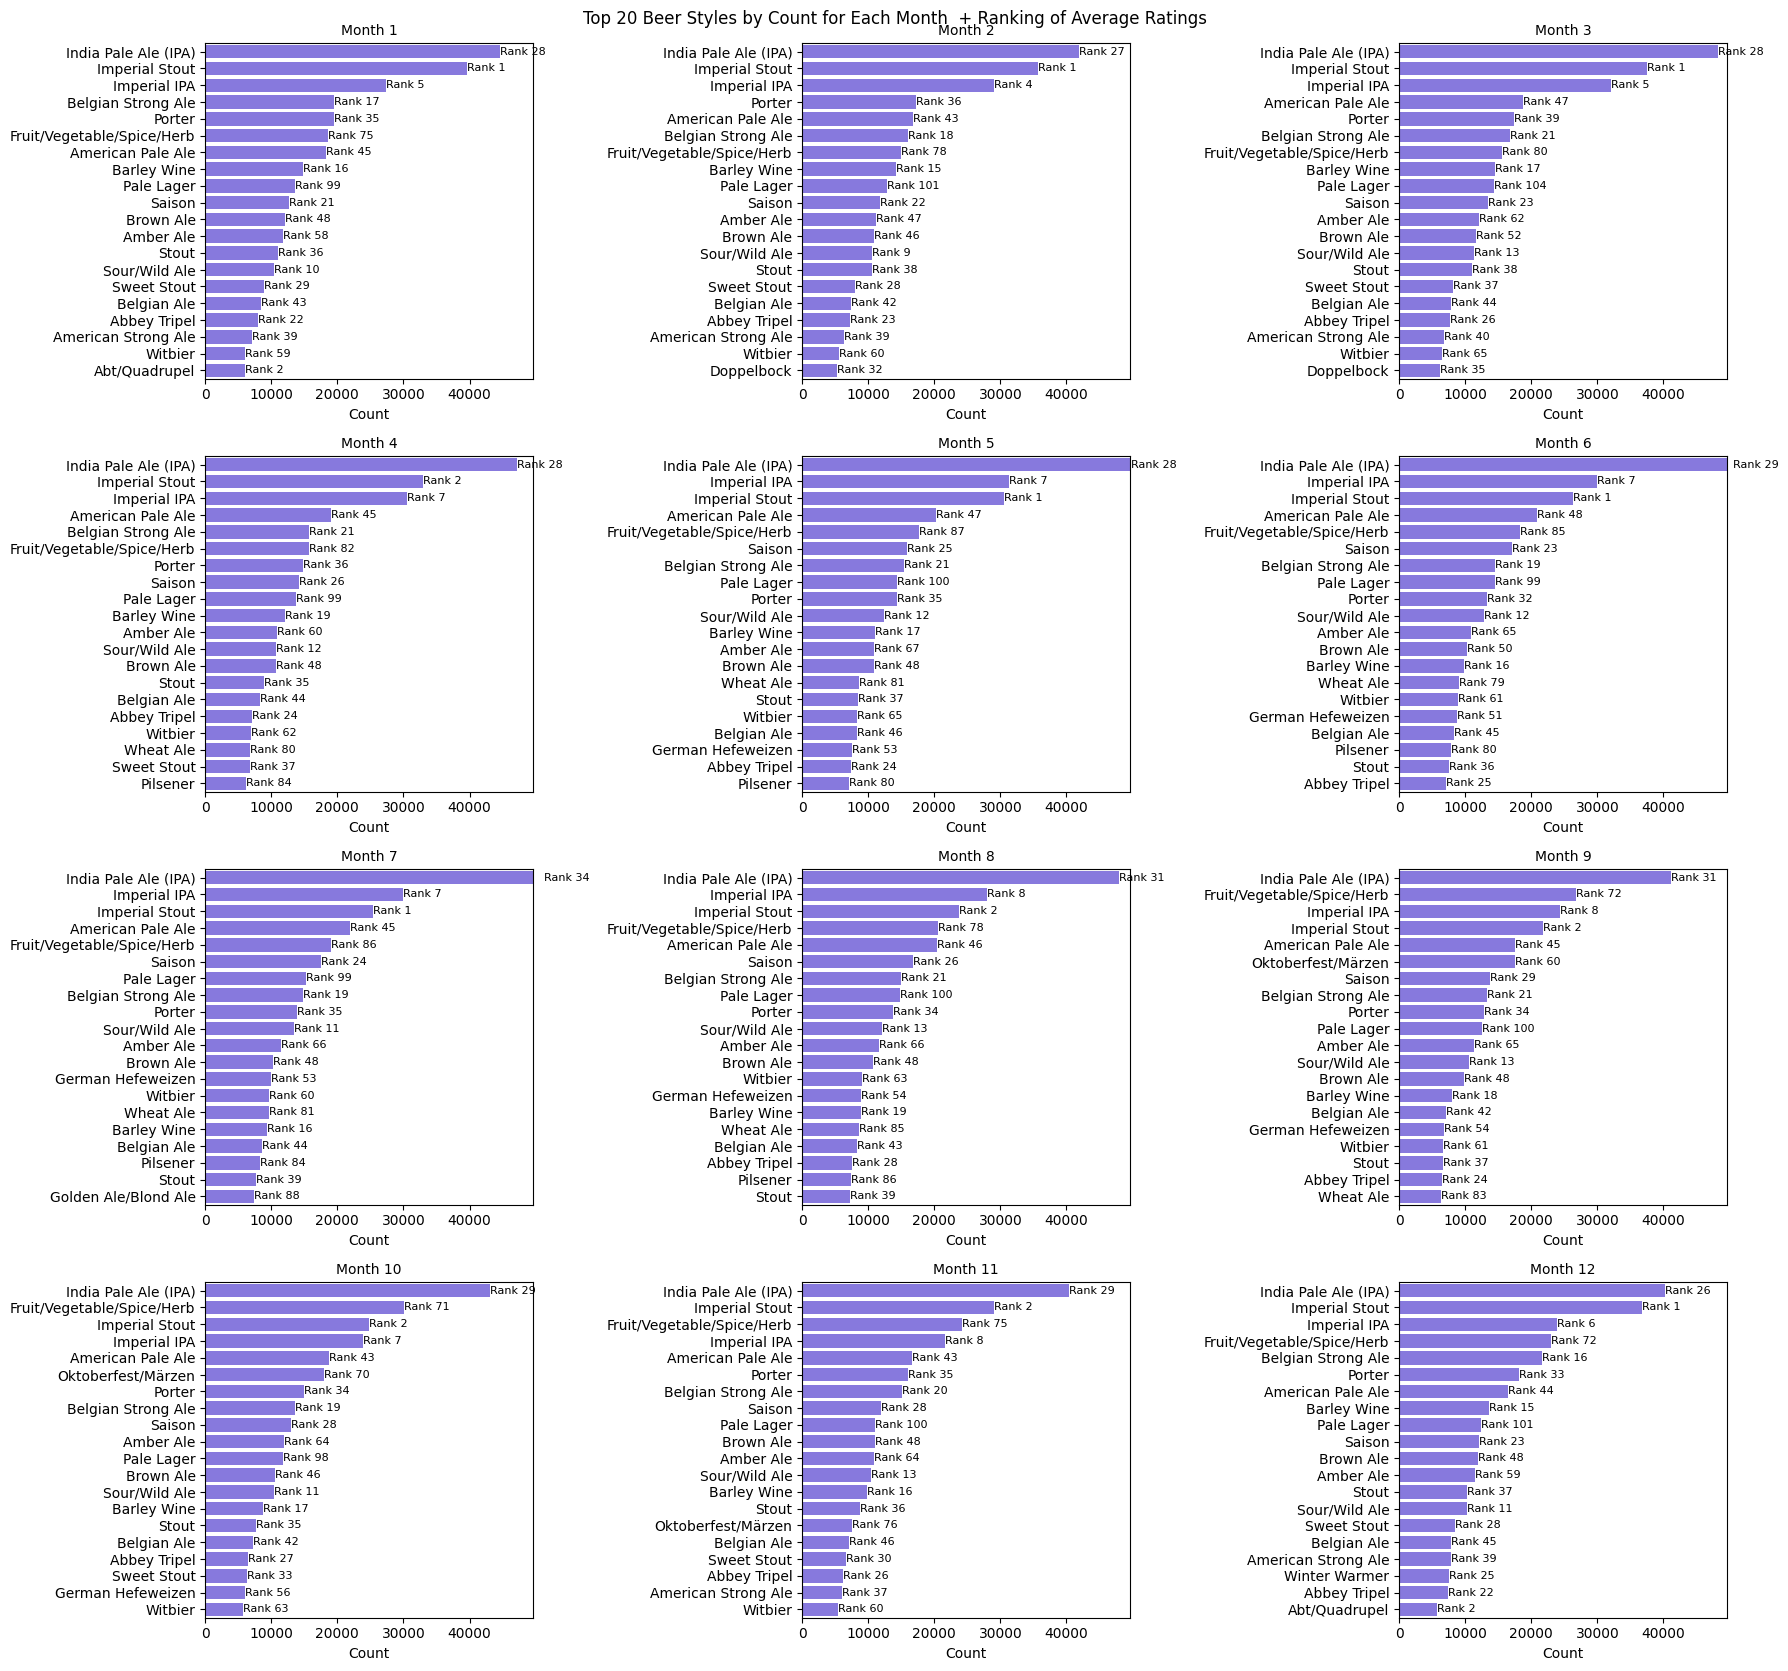

Number of styles that appear in the top 20 for at least one month: 
 27
Style Occurrences:
Abbey Tripel: 11 times
Abt/Quadrupel: 2 times
Amber Ale: 12 times
American Pale Ale: 12 times
American Strong Ale: 5 times
Barley Wine: 12 times
Belgian Ale: 12 times
Belgian Strong Ale: 12 times
Brown Ale: 12 times
Doppelbock: 2 times
Fruit/Vegetable/Spice/Herb: 12 times
German Hefeweizen: 6 times
Golden Ale/Blond Ale: 1 times
Imperial IPA: 12 times
Imperial Stout: 12 times
India Pale Ale (IPA): 12 times
Oktoberfest/Märzen: 3 times
Pale Lager: 12 times
Pilsener: 5 times
Porter: 12 times
Saison: 12 times
Sour/Wild Ale: 12 times
Stout: 12 times
Sweet Stout: 7 times
Wheat Ale: 6 times
Winter Warmer: 1 times
Witbier: 11 times


In [58]:
unique_styles = sorted(ratings_combined_df['style'].unique())
print(f'Number of unique beer styles: {len(unique_styles)} \n')

# Number of top beer styles to plot
x = 20

fig, axes = plt.subplots(4, 3, figsize=(18, 17))
fig.suptitle(f'Top {x} Beer Styles by Count for Each Month  + Ranking of Average Ratings')

max_count_across_months = ratings_combined_df.groupby('month')['style'].value_counts().head(x).max()
style_occurrences = {style: 0 for style in unique_styles}

for month, ax in zip(range(1, 13), axes.flatten()):
    month_data = ratings_combined_df[ratings_combined_df['month'] == month]
    top_styles_by_count = month_data['style'].value_counts().head(x).index
    avg_ratings_by_style = month_data.groupby('style')['rating'].mean().sort_values(ascending=False)

    # Count the number of times each style appears in the top 20 for each month
    for style in top_styles_by_count:
        style_occurrences[style] += 1

    sns.countplot(y='style', data=month_data, order=top_styles_by_count, ax=ax, color='mediumslateblue')
    ax.set_title(f'Month {month}', fontsize=10)
    ax.set_xlabel('Count')
    ax.set_ylabel('')
    ax.set_xlim(0, max_count_across_months + 5000)
    for i, style in enumerate(top_styles_by_count):
        ranking = avg_ratings_by_style.index.get_loc(style) + 1
        ax.text(month_data['style'].value_counts()[i], i, f'Rank {ranking}', va='center', ha='left', color='black', fontsize=8)

plt.tight_layout()
plt.show()

# Print the style occurrences dictionary and remove styles that never appear in the top 20
style_occurrences = {style: count for style, count in style_occurrences.items() if count > 0}
print("Number of styles that appear in the top 20 for at least one month: \n", len(style_occurrences))
print("Style Occurrences:")
for style, count in style_occurrences.items():
    print(f"{style}: {count} times")

Let's now observe the average ratings per month of some Beer's style. Can we see any particular differences? Have those styles any period where the number of ratings increases?

In [59]:
sample_styles = ['Oktoberfest/Märzen', 'American Pale Ale', 'Fruit/Vegetable/Spice/Herb']

for style in sample_styles: 
    ratings_users_sample = ratings_combined_df[ratings_combined_df['style'] == style]

    # Group by year_month and count the number of ratings per year_month
    year_month_ratings_count_sample = ratings_users_sample.groupby('year_month')['year_month'].count()

    year_month_ratings_count_sample = pd.DataFrame({'year_month': year_month_ratings_count_sample.index, 'nbr_ratings': year_month_ratings_count_sample.values})

    year_month_ratings_count_sample['year'] = year_month_ratings_count_sample['year_month'].dt.year
    year_month_ratings_count_sample['month'] = year_month_ratings_count_sample['year_month'].dt.month

    # Keep only rows where the year is greater than 2011 and less than 2017 
    year_month_ratings_count_filtered = year_month_ratings_count_sample[(year_month_ratings_count_sample.year >= 2008) & (year_month_ratings_count_sample.year < 2017)]

    # Compute the mean number of ratings per month
    mean_ratings_per_month = year_month_ratings_count_filtered.groupby('month')['nbr_ratings'].mean().reset_index(name='mean_nbr_ratings')

    # Plot with plotly the mean number of ratings per month
    fig = px.line(year_month_ratings_count_filtered, x='month', y='nbr_ratings', color='year', title='Mean Number of Ratings per Month for {}'.format(style))
    fig.add_trace(go.Scatter(x=year_month_ratings_count_filtered.month, y=mean_ratings_per_month.mean_nbr_ratings, mode='lines', name='Mean Number of Ratings', line=dict(color='black', dash='dash', width=4)))

    fig.show()

From the three plots, we observe big differences of the average ratings over a year. The 'Oktoberfest/Märzen' style of beers has a big increases of the ratings during the Oktoberfest period, in October. During the rest of the year, the number of ratings is low and does not fluctuates at all.

One of the most rated style is the APA, and as observed in the plot, the number of ratings does not have huge increases at some period. The style is quite popular throughout the year.

# On the road for the perfect beer ! 

## Keyword analysis 

Each beer has a specific taste, aroma or appearance. As we want to create the best combination for a beer, we seek to extract the adjectives or nouns describing the aroma, taste, appearance or palate of the most popular beer. 

As a first step, we need to create a list of words for each of these categories. To do so, we extract the words that appear the most frequently around the nouns/synonyms of those categories in the textual reviews.

### 1. Keywords extraction

In [60]:
textual_ratings_df = ratings_combined_df.copy()

In [61]:
# drop the rows where the text is null
textual_ratings_df.dropna(subset=['text'], inplace=True)

In [62]:
# Keywords for each category
aroma_keywords = ['aroma', 'smell', 'fragrance', 'scent', 'finish']
taste_keywords = ['taste', 'flavor', 'palate']
palate_keywords = ['palate', 'mouthfeel', 'body', 'texture', 'feel']
appearance_keywords = ['appearance', 'color', 'look', 'pour', 'head', 'foam', 'lacing']
carbonation_keywords = ['carbonation', 'bubbles', 'fizz', 'carbonated']

In [63]:
# group by beer_id and count the number of reviews for each beer
beer_reviews_count = textual_ratings_df.groupby('beer_id').count()['text'].reset_index()

In [64]:
beer_reviews_count['text'].describe()

count    307169.000000
mean         17.760184
std          89.031297
min           1.000000
25%           1.000000
50%           3.000000
75%           7.000000
max        5497.000000
Name: text, dtype: float64

The average of ratings received for a beer is 16.46, rounded to 14, with a standard deviation of 89.74. 
Since we have a lot of beers, and some of them receive a large amount of reviews, we decide to threshold the reviews. 
We assume that, in general, beers receive kind of the same review when it is a good review, and same goes for bad reviews. That's why we split the reviews into two parts, so that we can construct dictionnaries for good and for bad reviews.

Let's keep a maximum review of 17 for each beer. 

In [65]:
# for each beer_id, keep a maximum sample of mean reviews
mean = 17
beer_reviews_sample = textual_ratings_df.groupby('beer_id').apply(lambda x: x.sample(min(len(x), mean))).reset_index(drop=True)

In [66]:
nlp = spacy.load('en_core_web_sm')

In [67]:
def extract_keywords(text, keywords):
    # Process the text with spaCy
    doc = nlp(text.lower())

    result = []
    for token in doc:
        if token.text.lower() in keywords:
            # Collect nearby adjectives and nouns
            nearby_words = []
            for nearby_token in doc[token.i - 3:token.i + 5]:
                if nearby_token.pos_ in ['ADJ', 'NOUN'] and not nearby_token.is_stop and len(nearby_token) > 2:
                    nearby_words.append(nearby_token.lemma_)
            result.extend(nearby_words)
            
    # remove the duplicates and the words that are in the keywords list
    result = list(set(result) - set(keywords))

    return result

In [68]:
# concatenate all the keywords aroma_keywords, taste_keywords, palate_keywords, appearance_keywords, carbonation_keywords
all_keywords = aroma_keywords + taste_keywords + palate_keywords + appearance_keywords + carbonation_keywords

# create a function to filter the keys from the dictionary
def filter_keywords(keywords):
    filtered_keywords = []
    
    for keyword in keywords:
        
        # remove the keyowrds that have special characters, numbers and punctuation
        if not re.match('^[a-zA-Z]+$', keyword):
            continue
        
        # remove the keywords that are less than 3 characters
        if len(keyword) < 3:
            continue
        
        # remove keywords that have the word 'beer' in them
        if keyword == 'beer':
            continue
        
        # remove keywords such as not, like, well, etc.
        if keyword in ['not', 'one', 'like', 'well', 'good', 'great', 'nice', 'little', 'much', 'really', 'bit', 'very', 'with', 'more', 'and', 'but', 'too', 'also', 'just']:
            continue
        
        # remove words such as hop, hoppy, malt, malty, etc.
        if keyword in ['hop', 'hops', 'hoppy', 'malt', 'malts', 'malty', 'maltiness', 'maltinesses']:
            continue
        
        # if the keyword is not in the all_keywords list, add it to the filtered_keywords list
        if keyword not in all_keywords:
            filtered_keywords.append(keyword)
    
    return filtered_keywords

In [69]:
#good_aroma_list = []
#good_taste_list = []
#good_palate_list = []
#good_appearance_list = []
#good_carbonation_list = []

#sample_reviews = beer_reviews_sample['text'].sample(100000)

#for i, text in enumerate(sample_reviews.values):
    # for each keyword list, extract the keywords from the text
    #good_aroma_list.extend(extract_keywords(text, aroma_keywords))
    #good_taste_list.extend(extract_keywords(text, taste_keywords))
    #good_palate_list.extend(extract_keywords(text, palate_keywords))
    #good_appearance_list.extend(extract_keywords(text, appearance_keywords))
    #good_carbonation_list.extend(extract_keywords(text, carbonation_keywords))
    
    #aroma_set = Counter(good_aroma_list)
    #taste_set = Counter(good_taste_list)
    #palate_set = Counter(good_palate_list)
    #appearance_set = Counter(good_appearance_list)
    #carbonation_set = Counter(good_carbonation_list)
    
    #if i % 1000 == 0:
        # save it into json files
        #with open('data/aroma_keywords.json', 'w') as f:
           # json.dump(aroma_set, f)
        
        #with open('data/taste_keywords.json', 'w') as f:
            #json.dump(taste_set, f)
        
        #with open('data/palate_keywords.json', 'w') as f:
          #  json.dump(palate_set, f)
        
       # with open('data/appearance_keywords.json', 'w') as f:
           # json.dump(appearance_set, f)
        
        #with open('data/carbonation_keywords.json', 'w') as f:
          #  json.dump(carbonation_set, f)
            
        #print("File saved at iteration", i)

In [70]:
# filter the keywords
#aroma_words = filter_keywords(aroma_set.keys())
#taste_words = filter_keywords(taste_set.keys())
#palate_words = filter_keywords(palate_set.keys())
#appearance_words = filter_keywords(appearance_set.keys())
#carbonation_words = filter_keywords(carbonation_set.keys())

# reconstruct the dictionaries with the filtered keywords
#aroma_dict = {key: aroma_set[key] for key in aroma_words}
#taste_dict = {key: taste_set[key] for key in taste_words}
#palate_dict = {key: palate_set[key] for key in palate_words}
#appearance_dict = {key: appearance_set[key] for key in appearance_words}
#carbonation_dict = {key: carbonation_set[key] for key in carbonation_words}


In [71]:
# keep only the keywords that appear more than 100 times
# list of words to remove from the dictionary
appearance_terms = ['white', 'brown', 'light', 'small', 'thin', 'dark', 'golden', 'retention', 'medium', 'hazy', 'clear', 
                            'amber', 'black', 'creamy', 'thick', 'beige', 'orange', 'yellow', 'tan', 'foamy', 'copper', 'big', 
                            'gold', 'decent', 'deep', 'cloudy', 'lace', 'moderate', 'red', 'minimal', 
                            'ring', 'bright', 'colored', 'straw', 'dense', 'reddish', 'pale', 'khaki', 
                            'slight', 'rich', 'huge', 'fizzy', 'frothy', 'solid', 'average', 
                            'short', 'bubble', 'caramel', 'soft', 'pink', 'mocha', 'opaque', 'murky', 'ruby',
                            'rocky', 'fine', 'cling', 'cap', 'mahogany', 'brownish', 'ton', 'hue',  
                            'haze', 'pitch', 'clarity', 'wispy', 'cherry', 'highlight', 'clean', 'fade', 'funky', 
                            'ivory', 'purple', 'lacy', 'bone', 'high', 'hint', 'pinkish', 'peach', 'toffee',  'yellowish', 
                            'patchy', 'bronze', 'muddy', 'firm', 'clingy', 'stringy', 'visible', 'transparent']

taste_terms = ['sweet',  'bitter', 'smooth', 'roasted', 'dry', 'fruity', 'tart', 'bodied', 
    'bitterness', 'sour', 'strong', 'spice', 'mild', 'rich',  'yeast', 'profile', 'sweetness', 'earthy', 'balanced', 'alcohol', 
    'wheat', 'spicy', 'clean', 'moderate', 'crisp', 'grain', 'slight', 'heavy',
    'creamy', 'mid', 'complex', 'hint', 'roasty', 'bready', 'bread', 'roast', 'herbal', 'fresh', 'sugar', 'balance', 
    'solid', 'soft', 'juicy', 'subtle', 'grass', 'grassy', 'smoke',
    'funk', 'nutty', 'character', 'refreshing', 'citrusy', 'belgian', 'decent', 'bittersweet', 
    'rye', 'thick', 'thin', 'piney', 'grainy', 'clove', 'yeasty', 
    'wine', 'molasse', 'ale', 'biscuit', 'funky', 'bud', 'plenty', 'peppery', 'milk', 'barrel', 'tartness', 
    'smoky', 'woody', 'faint', 'toast', 'low', 'stout', 
    'ester', 'ton', 'bold', 'intense', 'deep', 'suit', 'brew', 'tangy', 'whiskey', 'blend', 'peel', 
    'tasty', 'ipa', 'acidic', 'straw', 'boozy', 'fruitiness', 'smokey', 'mellow', 'earthiness', 'juice', 'toasty', 'booze', 
    'average', 'tone', 'dough', 'robust', 'sourness', 'cracker', 'noticeable', 'biscuity', 
    'rind', 'barley', 'lager', 'cream', 'plum', 'acidity',  'hoppiness', 'upfront', 
    'resinous', 'syrup', 'porter', 'vinegar', 'sugary',' bubblegum']

palate_terms = ['medium', 'light', 'smooth', 'creamy', 'dry', 'bodied', 'soft', 
                'thin', 'thick', 'moderate', 'crisp',  'sticky', 'slick', 
                'mid', 'solid', 'decent', 'mild', 'balanced', 'oily', 'chewy', 
                'deep', 'watery', 'silky', 'refreshing', 'strong', 'touch', 'balance', 'fizzy', 'character', 
                'fine', 'flat', 'full', 'hint', 'sharp', 'bready', 'foamy', 
                'viscous', 'chalky', 'effervescent', 'fluffy', 'grainy', 'gentle', 
                'prickly', 'tartness', 'bubbly', 'acidic', 'astringency']

aroma_terms = ['citrus', 'chocolate', 'fruit', 'fruity', 'coffee',  'floral',
    'caramel', 'pine', 'grapefruit', 'tropical', 'vanilla', 'lemon', 'bourbon', 'cherry', 
    'orange', 'herbal', 'decent', 'citrusy', 'cocoa', 'honey', 'oak', 
    'toffee', 'nutty', 'banana', 'grass', 'apple', 
    'pepper', 'pineapple', 'thin', 'funk', 'clove', 'wood', 
    'berry', 'woody', 'biscuit', 'raspberry', 'grape', 'molasse', 
    'tangy', 'barrel', 'peach', 'raisin', 'resinous', 
    'candy', 'ipa',  'nut', 'pungent', 'pumpkin', 'ginger', 
    'mango', 'warming', 'earth', 'mellow', 'cereal', 'ring', 'astringent', 
    'coriander', 'tangerine', 'maple', 'melon', 'hay', 'lactic', 'citric', 
    'peel', 'rind', 'lager', 'bold', 'vinous', 'weak', 'toasted', 'blueberry', 
    'biscuity', 'spiced', 'lime', 'metallic', 'coconut', 'hay'
]

### 3. General analysis of the attributes 

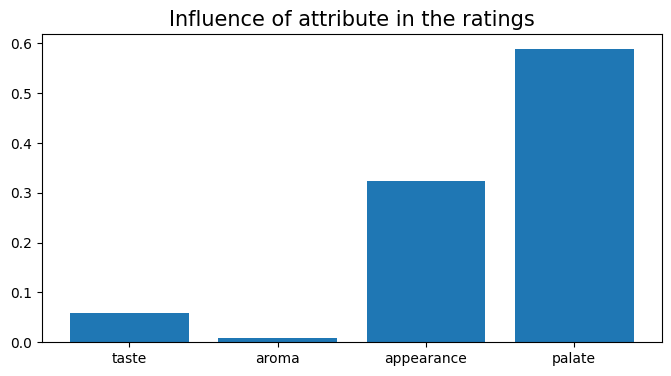

                                 OLS Regression Results                                
Dep. Variable:                 rating   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          9.431e+07
Date:                Tue, 19 Dec 2023   Prob (F-statistic):                        0.00
Time:                        00:03:27   Log-Likelihood:                     -1.1267e+06
No. Observations:             3185975   AIC:                                  2.253e+06
Df Residuals:                 3185971   BIC:                                  2.253e+06
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [72]:
textual_ratings_df.dropna(inplace=True)

X = textual_ratings_df[['taste', 'aroma', 'appearance', 'palate']]
y = textual_ratings_df['rating']


clf = linear_model.LinearRegression(fit_intercept=False)
clf.fit(X, y)
weights = clf.coef_
plt.figure(figsize = (8, 4))
plt.bar(x = ['taste', 'aroma', 'appearance', 'palate'], height = weights)
plt.title('Influence of attribute in the ratings', fontsize=15)
plt.grid(False)
plt.show()

ols = sm.OLS(y, X)
model = ols.fit()

print(model.summary())

Let's observe if there is any difference between months. 

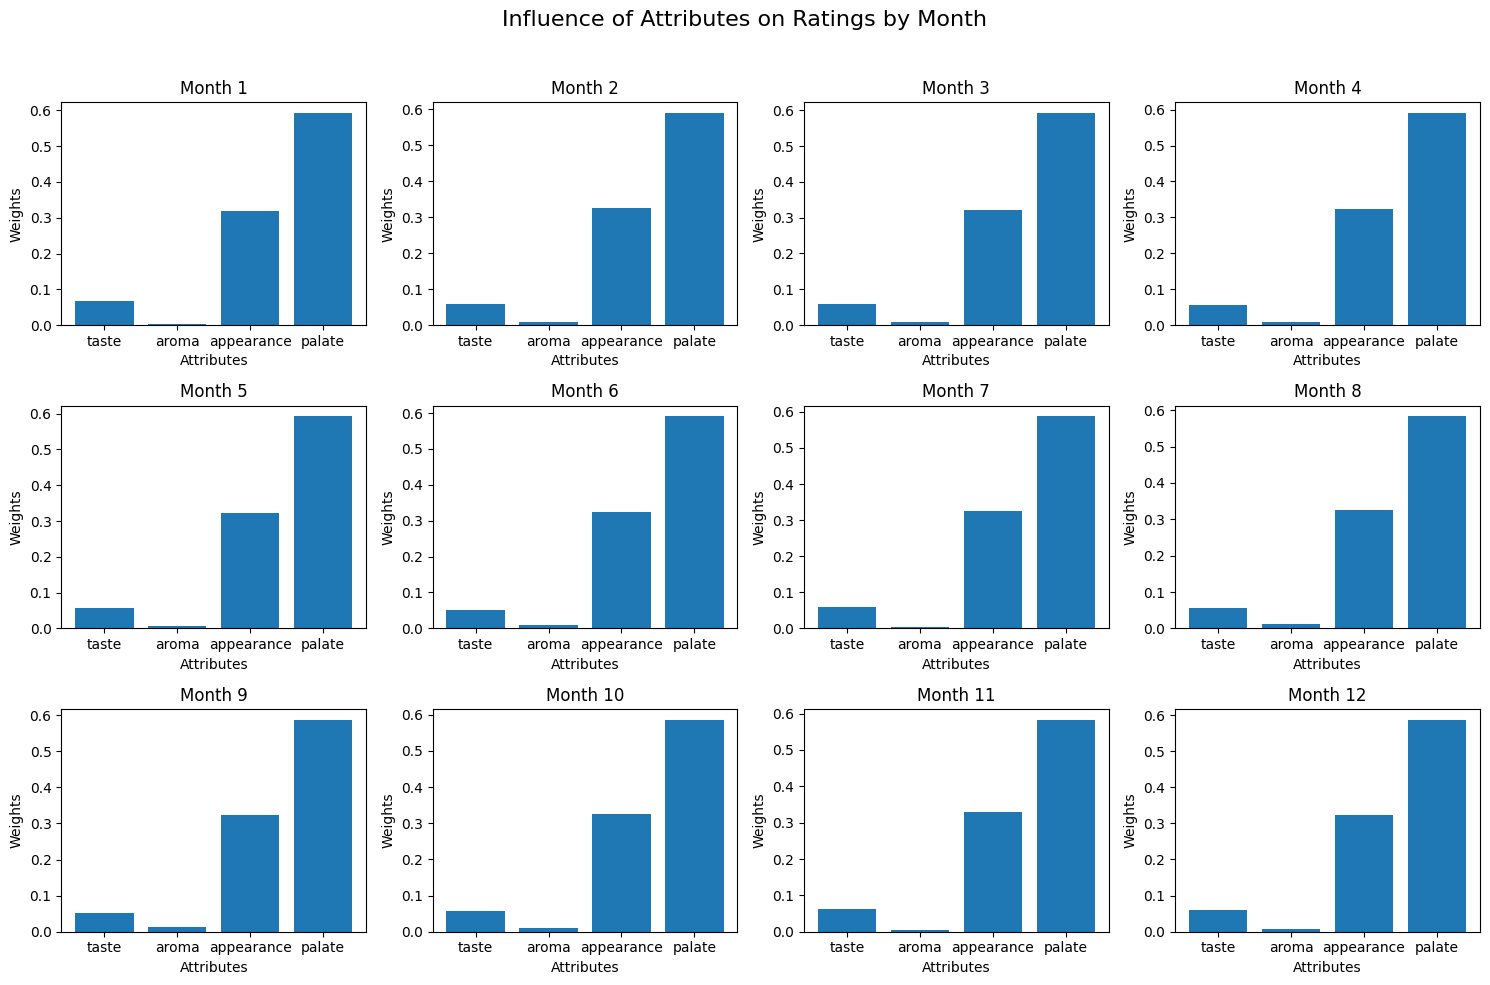

In [73]:
# List of months
months = sorted(textual_ratings_df['month'].unique())

# Set up subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle('Influence of Attributes on Ratings by Month', fontsize=16)

# Flatten the 3x4 subplot grid into a 1D array for iteration
axes = axes.flatten()

for i, month in enumerate(months):
    # Filter data for the current month
    month_df = textual_ratings_df[textual_ratings_df['month'] == month]
    
    # Define X and y for the current month
    X = month_df[['taste', 'aroma', 'appearance', 'palate']]
    y = month_df['rating']

    # Linear Regression
    clf = linear_model.LinearRegression(fit_intercept=False)
    clf.fit(X, y)
    weights = clf.coef_

    # Create a bar plot on the current subplot
    axes[i].bar(x=['taste', 'aroma', 'appearance', 'palate'], height=weights)
    axes[i].set_title(f'Month {month}')
    axes[i].set_xlabel('Attributes')
    axes[i].set_ylabel('Weights')
    axes[i].grid(False)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 2. Keywords of the most popular beer

Let's now extract the most frequent keywords for each attribute. The most frequent keywords are extracted from the most popular style. 

In [74]:
def matching_keywords(text, list_keywords):
    # Process the text with spaCy
    doc = nlp(text.lower())

    result = []
    for token in doc:
        token = token.lemma_
        if token in list_keywords:
            result.append(token)
    
    return result

We create the following function to extract the best style according to a rating. We use the lower bound of Wilson to rank the beers. 

In [75]:
def find_keywords_by_month_traditional(df, keywords_list, month, category, num_keywords, good=True):
    # Filter the DataFrame for the specified month
    month_df = df[df['month'] == month]

    # Find the best beer for the month based on average rating and review count
    beer_df = month_df.groupby('beer_id').agg({category: ['mean', 'count']}).reset_index()
    beer_df.columns = ['beer_id', 'average_rating', 'review_count']
    
    if (good):
        beer_stats = beer_df.sort_values(by=['review_count', 'average_rating'], ascending=[False, False])
    else:
        # keep only the beers that have at least 10 reviews
        beer_stats = beer_df[beer_df['review_count'] >= 100].sort_values(by=['average_rating'], ascending=True)

    # Get the beer ID of the best beer for the month
    beer_id = beer_stats.iloc[0]['beer_id']
    
    # print the best beer id for the month
    print(f"Beer for the month of {month}:", beer_id)

    # filter the dataframe with the 10 best beers for the month
    beer_reviews = month_df[month_df['beer_id'] == beer_id]
    
    # Extract keywords from reviews using a matching function (e.g., matching_keywords)
    keyword_list = []
    for text in beer_reviews['text'].values.tolist():
        keyword_list.extend(matching_keywords(text, keywords_list))

    # Count the number of times each keyword appears in the reviews
    keyword_counter = Counter(keyword_list)

    # Sort the dictionary by value
    sorted_keywords = dict(sorted(keyword_counter.items(), key=lambda item: item[1], reverse=True))

    # Return the top N keywords as a list of tuples (key, value)
    top_keywords = [(key, sorted_keywords[key]) for key in list(sorted_keywords.keys())[:num_keywords]]

    return beer_id, top_keywords

**Aroma Analysis**

Let's observe the most frequent keywords for the aroma attribute that appear for the most popular beer. To select the most popular beer, we first sort by the number of ratings and select the one with the highest average. 

It is also important to verify the validity of the extracted keywords. What if the same keywords appear for another less popular beer? 
To validate our results, we select a less popular beer and extract the most frequent keywords for each month. To select the least popular beer, we could select the one with the lowest number of rating, but this could lead us to only 1 rating, which does not reflect the opinion of a multiple people. Therefore, by a further analysis we observed that a beer receives in average 18 reviews with a standard deviation of approx. 89. Thus, we decide to threshold the beers to the ones having received at least 100 reviews, and among them we select the one with the lowest average rating. 

In [76]:
top_aroma_keywords_by_month = {}
best_aroma_beers = {}

bad_aroma_keywords_by_month = {}
worst_aroma_beers = {}

for month in range(1, 13):
    beer_id, top_aroma_keywords_by_month[month] = find_keywords_by_month_traditional(textual_ratings_df, aroma_terms, month, 'aroma', 10)
    best_aroma_beers[month] = beer_id
    print("Month", month)
    print("Good Aroma Keywords: ")
    print(top_aroma_keywords_by_month[month])
    
    beer_id, bad_aroma_keywords_by_month[month] = find_keywords_by_month_traditional(textual_ratings_df, aroma_terms, month, 'aroma', 10, False)
    worst_aroma_beers[month] = beer_id
    print("Bad Aroma Keywords: ")
    print(bad_aroma_keywords_by_month[month])
    print()

Beer for the month of 1: 17112.0
Month 1
Good Aroma Keywords: 
[('honey', 1082), ('citrus', 712), ('grapefruit', 651), ('orange', 560), ('pine', 471), ('ipa', 336), ('fruit', 264), ('pineapple', 258), ('floral', 243), ('tropical', 168)]
Beer for the month of 1: 1320.0
Bad Aroma Keywords: 
[('thin', 29), ('lager', 27), ('decent', 13), ('weak', 8), ('citrus', 6), ('lemon', 5), ('floral', 4), ('grass', 4), ('apple', 3), ('hay', 3)]

Beer for the month of 2: 17112.0
Month 2
Good Aroma Keywords: 
[('honey', 994), ('citrus', 711), ('grapefruit', 577), ('orange', 552), ('pine', 463), ('ipa', 436), ('fruit', 251), ('floral', 244), ('pineapple', 213), ('tropical', 179)]
Beer for the month of 2: 1320.0
Bad Aroma Keywords: 
[('thin', 30), ('lager', 19), ('metallic', 13), ('weak', 12), ('decent', 11), ('cereal', 10), ('apple', 6), ('caramel', 4), ('fruit', 3), ('ring', 3)]

Beer for the month of 3: 15881.0
Month 3
Good Aroma Keywords: 
[('citrus', 370), ('pine', 295), ('caramel', 255), ('grapefrui

We can quantify if the two beers are statistically different with a t-test.

In [77]:
def test_difference_beers(df, good_df, bad_df, category): 
    for month in range(1, 13):
        # Extract ratings for the two beers in the current month
        ratings_best = df[(df['beer_id'] == good_df[month]) & (df['month'] == month)][category]
        ratings_worst = df[(df['beer_id'] == bad_df[month]) & (df['month'] == month)][category]

        # Perform the Mann-Whitney U test
        t_statistic, p_value = st.ttest_ind(ratings_best, ratings_worst)

        # Print the results for each month
        print(f'Month: {month}')
        print(f'U-statistic: {t_statistic}')
        print(f'P-value: {p_value}')

        # Check if the difference is statistically significant at a 95% confidence level
        alpha = 0.05
        if p_value < alpha:
            print('The difference in ratings is statistically significant.')
        else:
            print('There is no significant difference in ratings.')

        print('\n')


**T-Test**:
* Null Hypothesis: There is no significant difference in the ratings of the two beers.
* Alternative Hypothesis: There is a significant difference in the ratings of the two beers.

In [78]:
test_difference_beers(textual_ratings_df, best_aroma_beers, worst_aroma_beers, 'aroma')

Month: 1
U-statistic: 60.15344682270072
P-value: 0.0
The difference in ratings is statistically significant.


Month: 2
U-statistic: 48.609000129018675
P-value: 7.508718875493215e-289
The difference in ratings is statistically significant.


Month: 3
U-statistic: 41.69379636959221
P-value: 1.0212770466466959e-193
The difference in ratings is statistically significant.


Month: 4
U-statistic: 56.18542607641533
P-value: 3.424213e-317
The difference in ratings is statistically significant.


Month: 5
U-statistic: 46.231167428540054
P-value: 1.6178031016988286e-184
The difference in ratings is statistically significant.


Month: 6
U-statistic: 41.57142861263493
P-value: 1.6056332315808216e-164
The difference in ratings is statistically significant.


Month: 7
U-statistic: 44.693165787379115
P-value: 2.191193464966022e-185
The difference in ratings is statistically significant.


Month: 8
U-statistic: 44.373795078083674
P-value: 1.2141090072944461e-166
The difference in ratings is statistic

The ratings for nearly each month between the best and worst beers are statistically significant, except for June and October. 
This emphasizes that the beers are not the same, and their keywords are relevant to analyze.

Let's observe a sample of the good reviews for the most popular beer.

In [79]:
# display a sample of revirews for the best beer for the month of January
print(textual_ratings_df[(textual_ratings_df['beer_id'] == best_aroma_beers[1]) & (textual_ratings_df['month'] == 1)]["text"].head(3).values)

['Wow! This beer lives up to its name and accomplishes what it sets out to do...slam you with hops. However, its brewed with honey and this adds a nice sweet character that smooths out the balance and makes it very drinkable. Not as much of a palette wrecker as it claims. Its bitterness gets balanced out with a sweet middle.A- Transparant honey tone with a craggy white foam that recedes to an oily sea foam layer that leaves nice rings of lace.S- Pungent pine, herbal and floral notes in front, plenty of citrus, orange peel zest, lemon, and grapefruit. Honey suckle.T- Complex resiny hop forward, full of floral and citrus, grapefruit and a silky honey note that sits nicely in the middel. Very balanced with a good bitter aftertaste, grassy notes.M- Slightly oily, nicely balanced, crisp and refreshing.D- Surpringly easier to drink than I expected. I believe its a sipper for those not ready for hops, but it delivered what it said it would and therefore gets a high score. I give it extra poin

Now, we can also observe a sample of reviews for the least rated beer selected. 

In [80]:
# display sample of reviews for the worst beer for the month of January
print(textual_ratings_df[(textual_ratings_df['beer_id'] == worst_aroma_beers[1]) & (textual_ratings_df['month'] == 1)]["text"].head(1).values)

["On tap. Served in a shaker pint. I believe this is my first Bud Light ... and my last. This is probably the most watery and tasteless beer I've ever had (possible exception: another An-Busch Light beer).  It almost certainly has less aroma than any other beer I've ever had.  I have good reason to suspect I have a rather sensitive sense of smell yet this beer has almost none. They shouldn't even call this beer."]


**Taste analysis**: 

In [81]:
top_taste_keywords_by_month = {}
best_taste_beers = {}

bad_taste_keywords_by_month = {}
worst_taste_beers = {}

for month in range(1, 13):
    beer_id, top_taste_keywords_by_month[month] = find_keywords_by_month_traditional(textual_ratings_df, taste_terms, month, 'taste', 10)
    best_taste_beers[month] = beer_id
    print("Month", month)
    print("Good Keywords:")
    print(top_taste_keywords_by_month[month])
    
    print("Bad Keywords:")
    beer_id, bad_taste_keywords_by_month[month] = find_keywords_by_month_traditional(textual_ratings_df, taste_terms, month, 'taste', 10, False)
    worst_taste_beers[month] = beer_id
    print(bad_taste_keywords_by_month[month])
    print()
    
    
test_difference_beers(textual_ratings_df, best_taste_beers, worst_taste_beers, 'taste')

Beer for the month of 1: 17112.0
Month 1
Good Keywords:
[('sweet', 682), ('alcohol', 528), ('sweetness', 420), ('bitter', 417), ('bitterness', 396), ('ipa', 336), ('smooth', 330), ('balance', 290), ('fresh', 264), ('brew', 225)]
Bad Keywords:
Beer for the month of 1: 1320.0
[('bud', 63), ('grain', 29), ('thin', 29), ('lager', 27), ('slight', 23), ('hint', 22), ('straw', 20), ('sweet', 18), ('faint', 16), ('grainy', 14)]

Beer for the month of 2: 17112.0
Month 2
Good Keywords:
[('sweet', 698), ('alcohol', 493), ('ipa', 436), ('sweetness', 431), ('bitter', 421), ('bitterness', 399), ('smooth', 325), ('balance', 284), ('strong', 219), ('brew', 213)]
Bad Keywords:
Beer for the month of 2: 1320.0
[('bud', 59), ('grain', 36), ('sweet', 34), ('thin', 30), ('faint', 22), ('straw', 21), ('lager', 19), ('hint', 19), ('grainy', 17), ('slight', 16)]

Beer for the month of 3: 15881.0
Month 3
Good Keywords:
[('sweet', 354), ('bitter', 231), ('bitterness', 222), ('balance', 196), ('smooth', 189), ('s

**Appearance analysis**: 

In [82]:
top_appearance_keywords_by_month = {}
best_appearance_beers = {}

bad_appearance_keywords_by_month = {}
worst_appearance_beers = {}

for month in range(1, 13):
    beer_id, top_appearance_keywords_by_month[month] = find_keywords_by_month_traditional(textual_ratings_df, appearance_terms, month, 'appearance', 10)
    best_appearance_beers[month] = beer_id
    print("Month", month)
    print("Good Keywords:")
    print(top_appearance_keywords_by_month[month])
    
    print("Bad Keywords:")
    beer_id, bad_appearance_keywords_by_month[month] = find_keywords_by_month_traditional(textual_ratings_df, appearance_terms, month, 'appearance', 10, False)
    worst_appearance_beers[month] = beer_id
    print(bad_appearance_keywords_by_month[month])
    print()
    
    
test_difference_beers(textual_ratings_df, best_appearance_beers, worst_appearance_beers, 'appearance')

Beer for the month of 1: 17112.0
Month 1
Good Keywords:
[('orange', 560), ('white', 455), ('light', 345), ('golden', 337), ('medium', 316), ('big', 259), ('high', 206), ('amber', 199), ('clear', 196), ('thick', 194)]
Bad Keywords:
Beer for the month of 1: 837.0
[('light', 148), ('yellow', 39), ('clear', 31), ('white', 25), ('thin', 20), ('pale', 18), ('straw', 17), ('slight', 16), ('hint', 14), ('decent', 13)]

Beer for the month of 2: 17112.0
Month 2
Good Keywords:
[('orange', 552), ('white', 455), ('light', 345), ('medium', 328), ('golden', 298), ('big', 252), ('amber', 225), ('slight', 199), ('hint', 197), ('clear', 192)]
Bad Keywords:
Beer for the month of 2: 837.0
[('light', 144), ('yellow', 43), ('pale', 31), ('thin', 26), ('clear', 24), ('white', 24), ('straw', 17), ('slight', 15), ('hint', 11), ('clean', 11)]

Beer for the month of 3: 15881.0
Month 3
Good Keywords:
[('amber', 565), ('white', 275), ('caramel', 255), ('orange', 238), ('medium', 232), ('clear', 204), ('light', 203

**Palate analysis**: 

In [83]:
top_palate_keywords_by_month = {}
best_palate_beers = {}

bad_palate_keywords_by_month = {}
worst_palate_beers = {}

for month in range(1, 13):
    beer_id, top_palate_keywords_by_month[month] = find_keywords_by_month_traditional(textual_ratings_df, palate_terms, month, 'palate', 10)
    best_palate_beers[month] = beer_id
    print("Month", month)
    print("Good Keywords:")
    print(top_palate_keywords_by_month[month])
    
    print("Bad Keywords:")
    beer_id, bad_palate_keywords_by_month[month] = find_keywords_by_month_traditional(textual_ratings_df, palate_terms, month, 'palate', 10, False)
    worst_palate_beers[month] = beer_id
    print(bad_palate_keywords_by_month[month])
    print()
    
    
test_difference_beers(textual_ratings_df, best_palate_beers, worst_palate_beers, 'palate')

Beer for the month of 1: 17112.0
Month 1
Good Keywords:
[('light', 345), ('smooth', 330), ('medium', 316), ('balance', 290), ('balanced', 213), ('strong', 211), ('thick', 194), ('dry', 169), ('creamy', 157), ('hint', 155)]
Bad Keywords:
Beer for the month of 1: 1320.0
[('light', 198), ('watery', 37), ('thin', 29), ('hint', 22), ('grainy', 14), ('fizzy', 13), ('refreshing', 13), ('decent', 13), ('crisp', 11), ('dry', 10)]

Beer for the month of 2: 17112.0
Month 2
Good Keywords:
[('light', 345), ('medium', 328), ('smooth', 325), ('balance', 284), ('strong', 219), ('balanced', 203), ('hint', 197), ('full', 181), ('thick', 162), ('dry', 152)]
Bad Keywords:
Beer for the month of 2: 1320.0
[('light', 197), ('thin', 30), ('watery', 29), ('hint', 19), ('grainy', 17), ('refreshing', 14), ('smooth', 14), ('crisp', 13), ('fizzy', 12), ('dry', 12)]

Beer for the month of 3: 15881.0
Month 3
Good Keywords:
[('medium', 232), ('light', 203), ('balance', 196), ('smooth', 189), ('strong', 128), ('balanc

**Further analysis**: 

In [93]:
first_aroma = {month_data[0][0] for month_data in top_aroma_keywords_by_month.values()}
first_aroma = list(first_aroma)
first_aroma

['pine', 'honey', 'ipa', 'bourbon', 'pumpkin', 'citrus']

The most frequent keywords for aroma are *bourbon*, *citruc*, *honey*, *ipa*, *pine* and *pumpkin*. Let's observe the variation of the number of ratings monthly. 

In [100]:
for keyword in first_aroma:
    textual_ratings_df[keyword] = textual_ratings_df['text'].apply(lambda x: x.lower().count(keyword))
    
textual_ratings_df_keywords = textual_ratings_df.groupby(['year', 'month'])[first_aroma].sum().reset_index()

# groupy by month and compute the mean of each column and standard deviation
textual_ratings_df_keywords_monthly = textual_ratings_df_keywords.groupby('month')[first_aroma].mean().reset_index()

In [103]:
# plot with plotly the mean number of ratings per month with standard deviation
fig = px.line(textual_ratings_df_keywords_monthly, x='month', y=first_aroma, title='Mean Number of Keywords per Month')
fig.show()